# Make-o-Matic Gesture Recognition

2017 by Thomas Lidy, TU Wien

### Requirements

Python 2.7

pip install -r requirements.txt

Tested on OS: Ubuntu 16.04.3 LTS

In [1]:
import numpy as np
import pandas as pd
import json
import time # for time measuring
import datetime # for time printing

from scipy import stats

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# Machine Learning
from sklearn import preprocessing, svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def str_to_int(string):
    '''cut away first character and convert to int - used to convert Gesture IDs like "G01" to 1'''
    return int(string[1:])

In [3]:
def timestr(seconds):
    ''' returns HH:MM:ss formatted time string for given seconds
    (seconds can be a float with milliseconds included, but only the integer part will be used)
    :return: string
    '''
    return str(datetime.timedelta(seconds=int(seconds)))

## Read Data

In [4]:
# main data
csv_file = 'data/EXPORT_09042017173622.csv'

# json files to translate gestures, parcours into long text
#gestures_file = 'data/gestures.json' # this is the file edited manually by us to conform to json
gestures_file = 'data/gestures.json.orig' # this is the file edited manually by us to conform to json
parcours_file = 'data/parcours.json'
mutations_file = 'data/mutations.json'

files = (gestures_file, parcours_file, mutations_file)
dataframes = []

# NOTE THAT THESE JSON FILES ARE NOT JSON CONFORM
# each line is a json string on its own, so we need to process the json line by line and combine THEN into a list

In [5]:
def get_oid(oid_dict):
    # get from the original representation {u'$oid': u'589c8ed31337b5ab1e1be121'} just the oid
    return oid_dict['$oid']

In [6]:
# get meta-files with descriptions of gestures, parcours and mutations
for filename in files:
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]   # .decode("utf-8")

    lines = [json.loads(line) for line in lines]
    
    # convert list of json lines into Dataframe
    df = pd.DataFrame.from_dict(lines)
    
    # convert long $oid to short
    df['_id'] = df['_id'].apply(get_oid)
    
    # set the real id
    df.set_index('id', inplace=True)
    
    # convert index (ID) from string like 'G01' to int
    df.index = df.index.map(str_to_int)
    
    dataframes.append(df)

In [7]:
(gestures_df, parcours_df, mutations_df) = tuple(dataframes)

In [8]:
gestures_df

,_id,isGarbage,isNesture,name,slug
1,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
2,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
3,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
4,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
5,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
6,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
7,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
8,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
9,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr
10,58a23a22d82675640470944f,NaN,NaN,Kontinuierliche Rotation groß linksrum,rcbl


In [9]:
gestures_df[['name','isNesture']]

,name,isNesture
1,Single Rotation klein rechtsrum,NaN
2,Single Rotation klein linksrum,NaN
3,Oszillierende Rotation klein rechtsrum,NaN
4,Oszillierende Rotation klein linksrum,NaN
5,Single Rotation groß rechtsrum,NaN
6,Single Rotation groß linksrum,NaN
7,Oszillierende Rotation groß rechtsrum,NaN
8,Oszillierende Rotation groß linksrum,NaN
9,Kontinuierliche Rotation groß rechtsrum,NaN
10,Kontinuierliche Rotation groß linksrum,NaN


In [10]:
#gestures_df.to_csv('data/gestures.csv', sep=';', encoding='utf-8')

In [11]:
# "positive" gestures to recognize (not nestures)
gestures_pos = gestures_df[gestures_df['isNesture'] != True].index.tolist()
gestures_pos

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [12]:
# "negative" gestures (nestures)
gestures_neg = gestures_df[gestures_df['isNesture'] == True].index.tolist()
nestures = gestures_neg # synonym
gestures_neg

[14, 15, 16, 17, 18]

In [13]:
parcours_df

,_id,comment,exercises,pose
101,589c897d1337b5ab1e1be118,Zwinge X locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
102,589c8ba71337b5ab1e1be11c,Zwinge X locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
103,589c8dbd1337b5ab1e1be11f,Zwinge X locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
104,589c8ed31337b5ab1e1be121,Zwinge X fest links- und rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
105,589c8fcc1337b5ab1e1be125,Zwinge X oszilierend linksdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
106,589c901a1337b5ab1e1be127,Zwinge X oszilierend rechtsdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
107,589c90e31337b5ab1e1be12c,Zwinge Y locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
108,589c911c1337b5ab1e1be12e,Zwinge Y locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
109,589c91961337b5ab1e1be132,Zwinge Y locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
110,589c92351337b5ab1e1be134,Zwinge Y fest links- und rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...


In [14]:
parcours_df.loc[101,'exercises']

[{u'mutation': {u'id': u'M151'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}}]

In [15]:
parcours_df.loc[101,'pose']

{u'start': u'Host 008 ist auf Werkbank fixiert, Griffachse X, untere Spannbacke fixiert (Xcm), Gewinde genau in Mitte. Subject steht frontal vor Werkbank, etwas links von Host, F\xfc\xdfe in Schulterbreite, Arme h\xe4ngen locker hinunter.'}

In [16]:
mutations_df

,_id,hands,params,slug
101,58a24ffa5097dc5998d3c5d0,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabaaaba
102,58a24ffa5097dc5998d3c5d1,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabababa
103,58a24ffa5097dc5998d3c5d2,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbaaaba
104,58a24ffa5097dc5998d3c5d3,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbababa
105,58a24ffa5097dc5998d3c5d4,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaacbaabba
106,58a24ffa5097dc5998d3c5d5,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaadbabbba
107,58a24ffa5097dc5998d3c5d6,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabaaaba
108,58a24ffa5097dc5998d3c5d7,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabababa
109,58a24ffa5097dc5998d3c5d8,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaabbaaaba
110,58a24ffa5097dc5998d3c5d9,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaabbababa


In [17]:
mutations_df.loc[151,'hands']

{u'right': {u'gesture': {u'id': u'G15'},
  u'host': {u'id': u'H008', u'name': u'Schraubzwinge klein'},
  u'instruction': u'zu Griff f\xfchren, greifen mit Faust'}}

In [18]:
mutations_df.loc[151,'params']

nan

In [19]:
mutations_df.loc[152,'hands']

{u'right': {u'gesture': {u'id': u'G17'},
  u'host': {u'id': u'H008', u'name': u'Schraubzwinge klein'},
  u'instruction': u'Umgreifen (Hand l\xf6sen, 90\xb0 Linksdrehung, Host mit Faust-Handhaltung erneut greifen)'}}

In [20]:
mutations_df.loc[101,'hands']

{u'right': {u'gesture': {u'id': u'G01'},
  u'host': {u'id': u'H008',
   u'name': u'Schraubzwinge klein',
   u'spot': {u'id': u'A', u'name': u'Drehgriff'}},
  u'instruction': u'Zwinge X locker rechtsdrehen einzeln'}}

In [21]:
mutations_df.loc[101,'params']

[{u'label': u'K\xf6rperhaltung', u'slug': u'm0', u'value': u'stehend'},
 {u'label': u'Spot', u'slug': u'm1', u'value': u'Drehgriff'},
 {u'label': u'Position Spot', u'slug': u'm2', u'value': u'mittig vor Subject'},
 {u'label': u'Orientierung Spot', u'slug': u'm3', u'value': u'Griffachse X'},
 {u'label': u'ausf\xfchrende Hand', u'slug': u'm4', u'value': u'Rechte'},
 {u'label': u'Handhaltung', u'slug': u'm5', u'value': u'Faust'},
 {u'label': u'Widerstand', u'slug': u'm6', u'value': u'keiner'},
 {u'label': u'Drehweise',
  u'slug': u'm7',
  u'value': u'ganze Hand mitbewegen, ganze Hand umgreifen'},
 {u'label': u'Drehwinkel', u'slug': u'm8', u'value': u'90\xb0'},
 {u'label': u'Drehrichtung',
  u'slug': u'm9',
  u'value': u'rechtsrum (schlie\xdfen)'},
 {u'label': u'Bewegungsablauf', u'slug': u'm10', u'value': u'einzeln'},
 {u'label': u'2. Hand', u'slug': u'm11', u'value': u'ruht woanders'}]

In [22]:
mutations_df.loc[101,'hands']['right']['gesture']['id']

u'G01'

In [23]:
mutations_df.loc[101,'params']

[{u'label': u'K\xf6rperhaltung', u'slug': u'm0', u'value': u'stehend'},
 {u'label': u'Spot', u'slug': u'm1', u'value': u'Drehgriff'},
 {u'label': u'Position Spot', u'slug': u'm2', u'value': u'mittig vor Subject'},
 {u'label': u'Orientierung Spot', u'slug': u'm3', u'value': u'Griffachse X'},
 {u'label': u'ausf\xfchrende Hand', u'slug': u'm4', u'value': u'Rechte'},
 {u'label': u'Handhaltung', u'slug': u'm5', u'value': u'Faust'},
 {u'label': u'Widerstand', u'slug': u'm6', u'value': u'keiner'},
 {u'label': u'Drehweise',
  u'slug': u'm7',
  u'value': u'ganze Hand mitbewegen, ganze Hand umgreifen'},
 {u'label': u'Drehwinkel', u'slug': u'm8', u'value': u'90\xb0'},
 {u'label': u'Drehrichtung',
  u'slug': u'm9',
  u'value': u'rechtsrum (schlie\xdfen)'},
 {u'label': u'Bewegungsablauf', u'slug': u'm10', u'value': u'einzeln'},
 {u'label': u'2. Hand', u'slug': u'm11', u'value': u'ruht woanders'}]

In [24]:
mutations_df.loc[151]

_id                                58a250245097dc5998d3c657
hands     {u'right': {u'host': {u'id': u'H008', u'name':...
params                                                  NaN
slug                                        Start - Greifen
Name: 151, dtype: object

### Define handy function shortcuts

In [25]:
def gesture_name(gesture_id):
    if gesture_id is None: return None
    return gestures_df.loc[gesture_id,'name']

In [26]:
def get_mutation_gesture(mutation_id):
    gest_str = mutations_df.ix[mutation_id,'hands']['right']['gesture']['id']
    return str_to_int(gest_str)

## Read Experiment Data

In [27]:
# Experiment Data
data = pd.read_csv(csv_file)
data.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1435576, 26)

In [28]:
data.shape

(1435576, 26)

In [29]:
data.columns

Index([u'Trainset-ID', u'Experiment-ID', u'Subject-ID', u'Observer-ID',
       u'collectedByHand', u'Collector-ID', u'TimeStamp', u'RFID-ID',
       u'GRASP-A', u'GRASP-B', u'GRASP-C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'USERINPUT', u'HANDINGLOVE', u' Parcours-ID', u'Parcours-Step',
       u'Mutation-ID', u' Mutation/HandIsActive', u'Host-ID', u'Host/Spot-ID',
       u'Gesture-ID'],
      dtype='object')

In [30]:
data.dtypes

Trainset-ID                object
Experiment-ID              object
Subject-ID                 object
Observer-ID                object
collectedByHand            object
Collector-ID               object
TimeStamp                   int64
RFID-ID                    object
GRASP-A                     int64
GRASP-B                     int64
GRASP-C                     int64
AX                        float64
AY                        float64
AZ                        float64
EX                        float64
EY                        float64
EZ                        float64
USERINPUT                    bool
HANDINGLOVE                  bool
 Parcours-ID               object
Parcours-Step               int64
Mutation-ID                object
 Mutation/HandIsActive       bool
Host-ID                    object
Host/Spot-ID               object
Gesture-ID                 object
dtype: object

In [31]:
data.head()

,Trainset-ID,Experiment-ID,Subject-ID,Observer-ID,collectedByHand,Collector-ID,TimeStamp,RFID-ID,GRASP-A,GRASP-B,...,EZ,USERINPUT,HANDINGLOVE,Parcours-ID,Parcours-Step,Mutation-ID,Mutation/HandIsActive,Host-ID,Host/Spot-ID,Gesture-ID
0,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,0,000000000000,781,8,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
1,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,19896,000000000000,212,213,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
2,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,29001,000000000000,782,0,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
3,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,29823,000000000000,179,185,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
4,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,46136,000000000000,782,6,...,-81.8750,False,True,P101,1,M151,True,H008,NaN,G15


## Some Data Stats

In [32]:
# how many subjects
subjects = data['Subject-ID'].unique().tolist()
subjects 

['Andreas', 'Alfred', 'Claudia', 'Dominik']

In [33]:
# how many observers
data['Observer-ID'].unique().tolist()

['Clemens']

In [34]:
# how many hands
data['Collector-ID'].unique().tolist()

['R01', 'L01']

In [35]:
# how many RFID ids
data['RFID-ID'].unique().tolist()

['000000000000',
 '09006734114B',
 0,
 '05003DD5CD20',
 '760057911BAB',
 '13005E4BB7B1',
 '1400135B8AD6',
 '14001486BE38',
 '7600577D0D51',
 '140014CD1AD7',
 '280015E55981',
 '05008C2F993F']

In [36]:
# how many experiments
experiments = data['Experiment-ID'].unique().tolist()
experiments

['E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008']

In [37]:
# how many training sets
len(data['Trainset-ID'].unique().tolist())

539

In [38]:
# how many parcours
len(data[' Parcours-ID'].unique())

116

In [39]:
data[' Parcours-ID'].unique()

array(['P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108',
       'P109', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116',
       'P117', 'P118', 'P401', 'P402', 'P403', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'P207', 'P208', 'P211', 'P212', 'P213',
       'P216', 'P217', 'P218', 'P221', 'P222', 'P223', 'P226', 'P227',
       'P228', 'P701', 'P702', 'P705', 'P706', 'P709', 'P710', 'P713',
       'P714', 'P801', 'P802', 'P601', 'P602', 'P603', 'P606', 'P607',
       'P608', 'P611', 'P612', 'P613', 'P616', 'P617', 'P618', 'P621',
       'P622', 'P623', 'P501', 'P502', 'P504', 'P503', 'P301', 'P302',
       'P306', 'P307', 'P308', 'P311', 'P312', 'P316', 'P317', 'P318',
       'P321', 'P322', 'P326', 'P327', 'P328', 'P119', 'P120', 'P121',
       'P231', 'P232', 'P234', 'P233', 'P236', 'P235', 'P717', 'P718',
       'P719', 'P720', 'P721', 'P722', 'P723', 'P724', 'P626', 'P627',
       'P628', 'P629', 'P630', 'P331', 'P332', 'P333', 'P334', 'P335',
      

In [40]:
# how many parcours steps
data['Parcours-Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [41]:
# how many mutations
len(data['Mutation-ID'].unique())

177

In [42]:
# how many gestures
len(data['Gesture-ID'].unique())

19

In [43]:
# which gestures exist
sorted(data['Gesture-ID'].unique())

[nan,
 'G01',
 'G02',
 'G03',
 'G04',
 'G05',
 'G06',
 'G07',
 'G08',
 'G09',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'G15',
 'G16',
 'G17',
 'G18']

In [44]:
# how many hosts
len(data['Host-ID'].unique())

10

In [45]:
# which Host Spots
data['Host/Spot-ID'].unique().tolist()

[nan, 'A', 'B', 'F']

## Data Preprocessing

In [46]:
# rename some columns as the - in the column name does not allow for data.query()) to be used
# cut off the "-ID" suffix, remove a leading space and replace - by _

for col in data.columns:
    if col.endswith('-ID'):
        data.rename(columns={col: col[:-3]}, inplace=True)
        print "Renamed", col, "->", col[:-3]
        col = col[:-3]
    if col.startswith(' '):
        data.rename(columns={col: col[1:]}, inplace=True)
        print "Renamed", col, "->", col[1:]
        col = col[1:]
    if '-' in col:
        new_col = col.replace('-','_')
        data.rename(columns={col: new_col}, inplace=True)
        print "Renamed", col, "->", new_col

Renamed Trainset-ID -> Trainset
Renamed Experiment-ID -> Experiment
Renamed Subject-ID -> Subject
Renamed Observer-ID -> Observer
Renamed Collector-ID -> Collector
Renamed RFID-ID -> RFID
Renamed GRASP-A -> GRASP_A
Renamed GRASP-B -> GRASP_B
Renamed GRASP-C -> GRASP_C
Renamed  Parcours-ID ->  Parcours
Renamed  Parcours -> Parcours
Renamed Parcours-Step -> Parcours_Step
Renamed Mutation-ID -> Mutation
Renamed  Mutation/HandIsActive -> Mutation/HandIsActive
Renamed Host-ID -> Host
Renamed Host/Spot-ID -> Host/Spot
Renamed Gesture-ID -> Gesture


In [47]:
# remove rows that are not needed:
# all where Gesture-ID is NaN  (implies 'Mutation/HandIsActive' == False and Host is NaN)

data.dropna(axis=0, subset=['Gesture'], inplace=True)

In [48]:
# remove columns that we don't need
# to be ignored as communicated by MOM
cols_to_remove = ['USERINPUT', 'HANDINGLOVE', 'Observer','Collector',
                  'Mutation/HandIsActive']
# originally included: 'Trainset', 'RFID', 'Parcours_Step'

data.drop(cols_to_remove,inplace=True,axis=1)

In [49]:
data.shape

(780299, 21)

In [50]:
data.head()

,Trainset,Experiment,Subject,collectedByHand,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,...,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,E001,Andreas,right,0,000000000000,781,8,797,0.06,...,-0.10,216.8125,9.0625,-81.9375,P101,1,M151,H008,NaN,G15
2,_TRAINSET14022017094616,E001,Andreas,right,29001,000000000000,782,0,799,0.09,...,-0.11,217.0625,9.0625,-81.9375,P101,1,M151,H008,NaN,G15
4,_TRAINSET14022017094616,E001,Andreas,right,46136,000000000000,782,6,798,0.12,...,0.09,217.4375,9.1250,-81.8750,P101,1,M151,H008,NaN,G15
6,_TRAINSET14022017094616,E001,Andreas,right,74902,000000000000,784,7,798,0.08,...,0.03,217.6250,9.1250,-81.8125,P101,1,M151,H008,NaN,G15
8,_TRAINSET14022017094616,E001,Andreas,right,97663,000000000000,781,0,798,0.07,...,0.04,217.9375,9.1875,-81.7500,P101,1,M151,H008,NaN,G15


In [51]:
# also in this evaluation, we use only one-hand devices and only people who are right-handers
data['collectedByHand'].unique().tolist()

['right', 'left']

In [52]:
# right hand data rows
sum(data['collectedByHand']=='right')

711360

In [53]:
# left hand data rows
sum(data['collectedByHand']=='left')

68939

In [54]:
# REMOVE left hand data, keep only left hand
data = data[data['collectedByHand']=='right']
data.shape

(711360, 21)

In [55]:
# REMOVE column collectedByHand 
del data['collectedByHand']

### Convert Columns with String IDs to numbers, for later improved efficiency

In [56]:
cols_to_convert = ['Experiment','Parcours','Mutation','Host','Gesture']

for c in cols_to_convert:
    data[c] = data[c].apply(str_to_int)

In [57]:
data.head()

,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,1,Andreas,0,000000000000,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,1,151,8,NaN,15
2,_TRAINSET14022017094616,1,Andreas,29001,000000000000,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,1,151,8,NaN,15
4,_TRAINSET14022017094616,1,Andreas,46136,000000000000,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,1,151,8,NaN,15
6,_TRAINSET14022017094616,1,Andreas,74902,000000000000,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,1,151,8,NaN,15
8,_TRAINSET14022017094616,1,Andreas,97663,000000000000,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,1,151,8,NaN,15


## Look into the Data

In [58]:
data.columns

Index([u'Trainset', u'Experiment', u'Subject', u'TimeStamp', u'RFID',
       u'GRASP_A', u'GRASP_B', u'GRASP_C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'Parcours', u'Parcours_Step', u'Mutation', u'Host',
       u'Host/Spot', u'Gesture'],
      dtype='object')

### Get Experiment data: Filter for one experiment of one subject (just for testing)

In [59]:
def get_experiment(data,experiment,trainset,subject,parcours,mutation,gesture):
    query = []
    # by passing None, some parts of these can be omitted (returning more data)
    if experiment: query.append('Experiment==@exp')
    if trainset: query.append('Trainset==@trainset')
    if subject: query.append('Subject==@subject')
    if parcours: query.append('Parcours==@parcours')
    if mutation: query.append('Mutation==@mutation')
    if gesture: query.append('Gesture==@gesture')
    # TODO filter by Parcours_Step u/o Host
    
    query = " and ".join(query)
    #print query
    return data.query(query)

### Get 1 Experiment

In [60]:
# get experiment data (setting one to None does not filter by it)
exp = 1
subject = 'Andreas'
trainset = None
parcours = None # 102
mutation = None
gesture = None #2 # 1

mydata = get_experiment(data,exp,trainset,subject,parcours,mutation,gesture)
mydata.shape

(66713, 20)

In [61]:
# if we queried without Parcours, use this to get all the Parcours
parcours = mydata['Parcours'].unique().tolist()
print len(parcours), "Parcours"

57 Parcours


In [62]:
# how many training sets included in this experiment
trainsets = mydata['Trainset'].unique().tolist()
print len(trainsets), "Train sets"

94 Train sets


In [63]:
# print first few
trainsets[:5]

['_TRAINSET14022017094616',
 '_TRAINSET14022017094807',
 '_TRAINSET14022017094852',
 '_TRAINSET14022017095229',
 '_TRAINSET14022017095429']

In [64]:
# how often does the Timestamp jump, i.e. start at 0 again?
sum(mydata['TimeStamp'].diff() < 0)

93

In [65]:
# -> seems right!

### Get 1 Trainset

In [66]:
# get experiment data (setting one to None does not filter by it)
exp = 1
subject = 'Andreas'
trainset = '_TRAINSET14022017094616'
parcours = None # 102
mutation = None
gesture = None #2 # 1

mydata = get_experiment(data,exp,trainset,subject,parcours,mutation,gesture)
mydata.shape

(1238, 20)

In [67]:
# which parcours
mydata['Parcours'].unique().tolist()

[101]

In [68]:
# which parcours-steps
mydata['Parcours_Step'].unique().tolist()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [69]:
group_by = ('Subject','Experiment','Trainset','Parcours','Parcours_Step')
mydata.groupby(group_by).size()

Subject  Experiment  Trainset                 Parcours  Parcours_Step
Andreas  1           _TRAINSET14022017094616  101       1                245
                                                        2                118
                                                        3                148
                                                        4                224
                                                        5                 84
                                                        6                104
                                                        7                 69
                                                        8                 88
                                                        9                 66
                                                        10                92
dtype: int64

In [70]:
# which gestures in each Parcours_Step
for idx, group_df in mydata.groupby(group_by):
    parcours_step = idx[-1] # last entry in index is the Parcours_Step
    print parcours_step, np.unique(group_df['Gesture']), len(group_df)

1 [15] 245
2 [1] 118
3 [17] 148
4 [1] 224
5 [17] 84
6 [1] 104
7 [17] 69
8 [1] 88
9 [17] 66
10 [1] 92


In [71]:
# which mutations
mut_list = mydata['Mutation'].unique().tolist()
mut_list

[151, 101, 152]

In [72]:
# which gestures
gest_list = mydata['Gesture'].unique().tolist()
gest_list

[15, 1, 17]

In [73]:
# which mutation corresponds to which gesture
for mut in mut_list:
    gest = get_mutation_gesture(mut)
    print mut, ":", gest, gesture_name(gest)

151 : 15 Greifen
101 : 1 Single Rotation klein rechtsrum
152 : 17 Umgreifen


In [74]:
# which RFIDs
mydata['RFID'].unique().tolist()

['000000000000']

### Get 1 Gesture

In [75]:
# get data for 1 gesture
mutation = None
parcours = 101
gesture = 15 
mydata = get_experiment(data,exp,trainset,subject,parcours,mutation,gesture)
mydata.head()

,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,1,Andreas,0,000000000000,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,1,151,8,NaN,15
2,_TRAINSET14022017094616,1,Andreas,29001,000000000000,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,1,151,8,NaN,15
4,_TRAINSET14022017094616,1,Andreas,46136,000000000000,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,1,151,8,NaN,15
6,_TRAINSET14022017094616,1,Andreas,74902,000000000000,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,1,151,8,NaN,15
8,_TRAINSET14022017094616,1,Andreas,97663,000000000000,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,1,151,8,NaN,15


In [76]:
### Check TimeStep deltas
# investigate time stamp delta mean and variance
mydata['TimeStamp'].diff().describe()

count      244.000000
mean     23688.918033
std      10407.436490
min       1580.000000
25%      16474.250000
50%      23934.500000
75%      28587.750000
max      70917.000000
Name: TimeStamp, dtype: float64

In [77]:
print "Average Time Stamp delta:", mydata['TimeStamp'].diff().mean()

Average Time Stamp delta: 23688.9180328


In [78]:
# how often does the Timestamp jump, i.e. start at 0 again?
sum(mydata['TimeStamp'].diff() < 0)

0

In [79]:
# -> should be 0: within a gesture there should be no TimeStamp reset!

### Plot timeline of sensor data of 1 Trainset

In [80]:
params = ['AX', 'AY', 'AZ', 'EX', 'EY', 'EZ', 'GRASP_A', 'GRASP_B', 'GRASP_C']
# TODO add RFID?

In [81]:
def one_plot(mydata,var):
    y = mydata[var]
    x = range(len(y))
    #x = mydata['TimeStamp']
    plt.plot(x, y)
    title = "E%s %s %s P%s M%s G%s %s" % (str(exp),subject,trainset,str(parcours),str(mutation),str(gesture),gesture_name(gesture)) 
    plt.title(title)
    #plt.show()

In [82]:
def grid_plot(mydata, title=True):
    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10)) #, sharex=True, sharey=True)
    if title is True:
        title = "E%s %s %s P%s M%s G%s %s" % (str(exp),subject,trainset,str(parcours),str(mutation),str(gesture),gesture_name(gesture)) 

    if title is not None:
        fig.suptitle(title, fontsize=16)

    axes_list = axes.reshape(-1)

    for i, var in enumerate(params):

        # data
        y = mydata[var]
        x = range(len(y))
        #x = mydata['TimeStamp']

        # subplot index
        r = i % rows
        c = int(i / rows)
        axes[r,c].plot(x, y)
        axes[r,c].set_title(var)
    

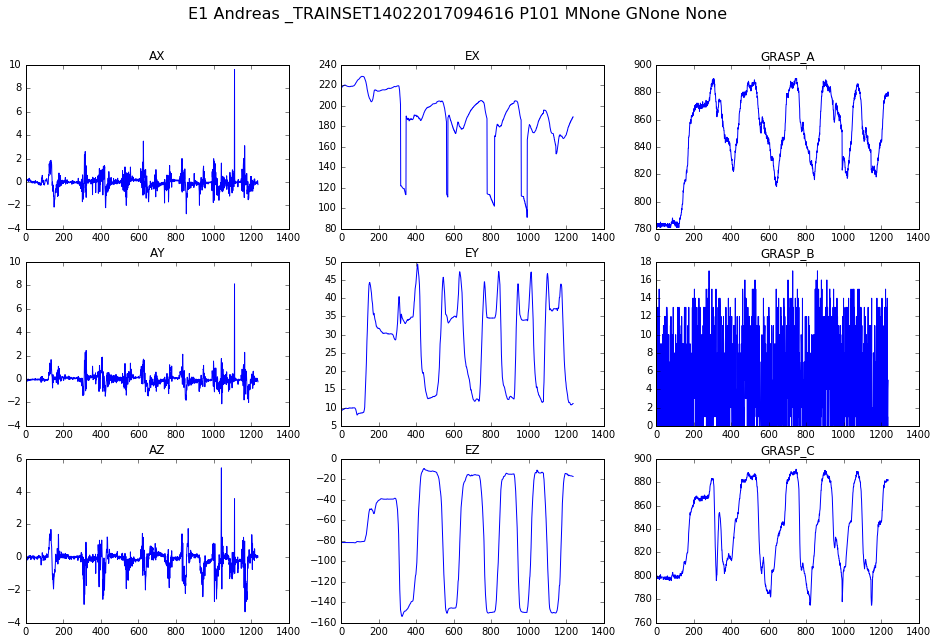

In [83]:
# show data for 1 PARCOURS
exp = 1
subject = 'Andreas'
trainset = trainsets[0]
parcours = 101
mutation = None
gesture = None 

mydata = get_experiment(data,exp,trainset,subject,parcours,mutation,gesture)

grid_plot(mydata)

Avg. TimeStamp delta: 25786.327405


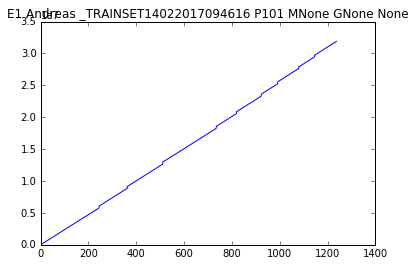

In [84]:
var = 'TimeStamp'
one_plot(mydata,var)
print "Avg. TimeStamp delta:", mydata['TimeStamp'].diff().mean()

#### = Nice continuous data

### Plot Gestures == Parcour-Steps inside 1 Trainset with different color:

In [85]:
# which / how many gestures are in this parcours?
gest_list = mydata['Gesture'].unique().tolist()

for g in gest_list:
    print "G", g, gesture_name(g)

G 15 Greifen
G 1 Single Rotation klein rechtsrum
G 17 Umgreifen


In [86]:
trainset

'_TRAINSET14022017094616'

In [87]:
var = 'EY'
mydata.head()

,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,1,Andreas,0,000000000000,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,1,151,8,NaN,15
2,_TRAINSET14022017094616,1,Andreas,29001,000000000000,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,1,151,8,NaN,15
4,_TRAINSET14022017094616,1,Andreas,46136,000000000000,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,1,151,8,NaN,15
6,_TRAINSET14022017094616,1,Andreas,74902,000000000000,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,1,151,8,NaN,15
8,_TRAINSET14022017094616,1,Andreas,97663,000000000000,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,1,151,8,NaN,15


In [88]:
from collections import OrderedDict

In [89]:
# define color map
n_gestures = len(gestures_df)
colors = matplotlib.cm.jet(np.linspace(0, 1, n_gestures))

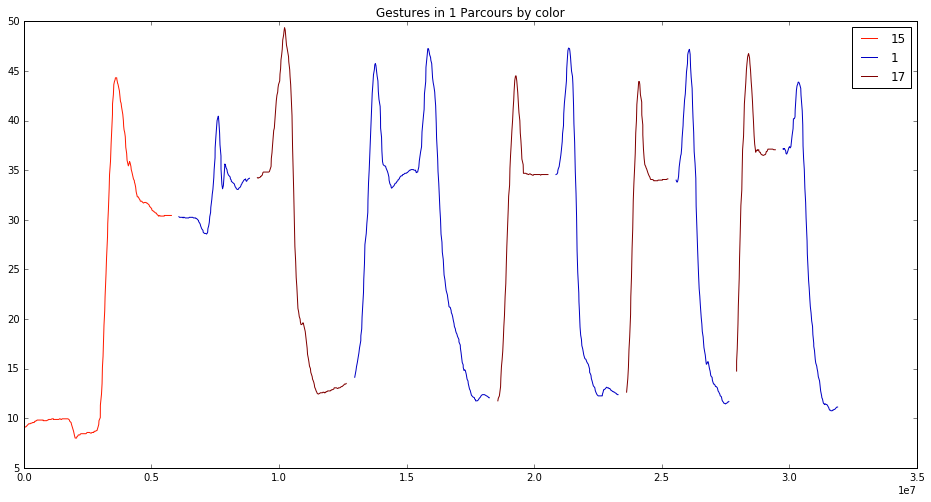

In [90]:
#print "Plot of gestures in 1 Parcours by different colours:"

group_data = mydata.groupby(('Parcours','Parcours_Step'))

plt.figure(figsize=(16,8))

for idx, group_df in group_data:
    gest_list = group_df['Gesture'].unique()
    if len(gest_list) != 1:
        raise ValueError("More than 1 gesture in parcours step:" + str(gest_list))
        
    gest = gest_list[0]
    color = tuple(colors[gest])
    plt.plot(group_df['TimeStamp'], group_df[var], color=color, label=str(gest))

# resorting lables in an OrderedDict as they would be repeated otherwise
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())  # loc='upper left')
plt.title("Gestures in 1 Parcours by color")
pass

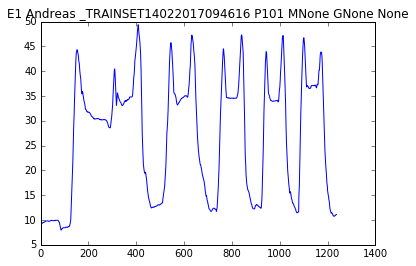

In [91]:
one_plot(mydata,var)

### Plot 1 Gesture

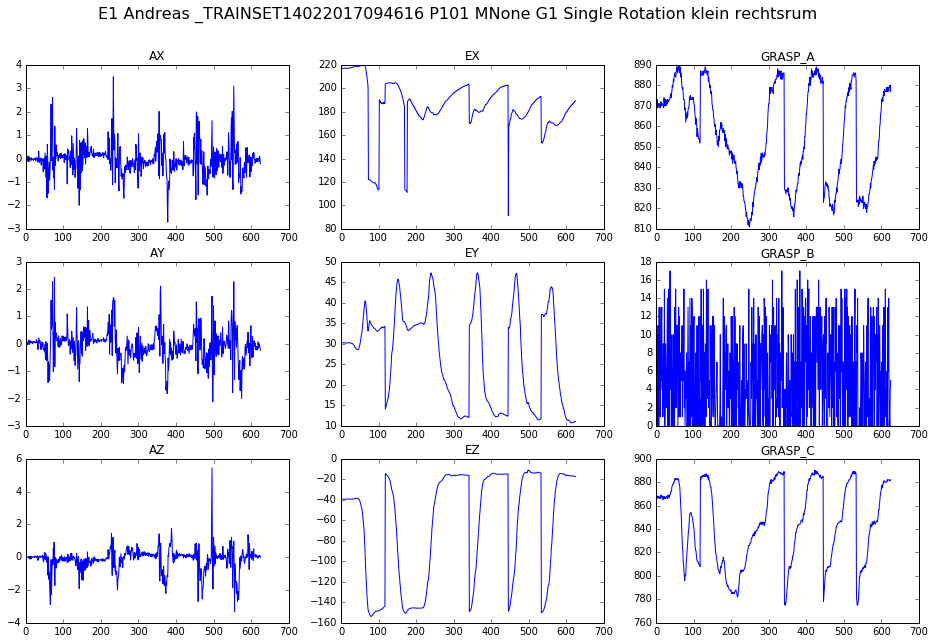

In [92]:
# get data for 1 GESTURE

mutation = None
gesture = 1

mydata = get_experiment(data,exp,trainset,subject,parcours,mutation,gesture)

grid_plot(mydata)

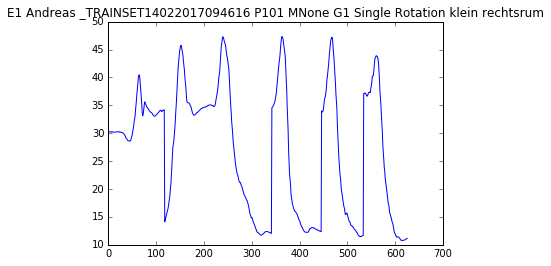

In [93]:

one_plot(mydata,'EY')

Avg. TimeStamp delta: 41318.1248


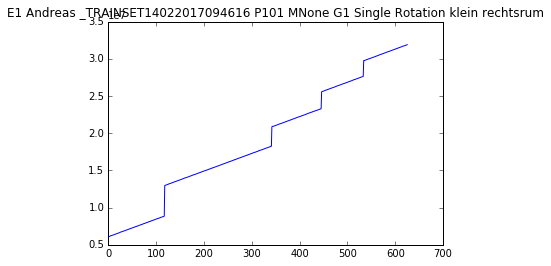

In [94]:
var = 'TimeStamp'
one_plot(mydata,var)
print "Avg. TimeStamp delta:", mydata['TimeStamp'].diff().mean()

#### = Cuts in the data! PROBLEM!!!

#### CONCLUSION: USE PARCOURS DATA - but it may contain multiple gestures - how to group them??

## Solution: Replace Nestures

In [95]:
replace_nestures = True

In [96]:
group_by = ('Subject','Experiment','Trainset','Parcours','Mutation','Gesture')
group_df = data.groupby(group_by)
print "Originally", len(group_df), "individual gesture blocks"

Originally 2045 individual gesture blocks


In [97]:
data.groupby(group_by).count().head()

TimeStamp  \
Subject Experiment Trainset                Parcours Mutation Gesture              
Alfred  2          _TRAINSET14022017144824 101      101      1              268   
                                                    151      15             142   
                                                    152      17             310   
                   _TRAINSET14022017144923 102      102      2              204   
                                                    151      15             142   

                                                                      RFID  \
Subject Experiment Trainset                Parcours Mutation Gesture         
Alfred  2          _TRAINSET14022017144824 101      101      1         268   
                                                    151      15        142   
                                                    152      17        310   
                   _TRAINSET14022017144923 102      102      2         204   
                                                    151      15        142   

                                                                      GRASP_A  \
Subject Experiment Trainset                Parcours Mutation Gesture            
Alfred  2          _TRAINSET14022017144824 101      101      1            268   
                                                    151      15           142   
                                                    152      17           310   
                   _TRAINSET14022017144923 102      102      2            204   
                                                    151      15           142   

                                                                      GRASP_B  \
Subject Experiment Trainset                Parcours Mutation Gesture            
Alfred  2          _TRAINSET14022017144824 101      101      1            268   
                                                    151      15           142   
                                                    152      17           310   
                   _TRAINSET14022017144923 102      102      2            204   
                                                    151      15           142   

                                                                      GRASP_C  \
Subject Experiment Trainset                Parcours Mutation Gesture            
Alfred  2          _TRAINSET14022017144824 101      101      1            268   
                                                    151      15           142   
                                                    152      17           310   
                   _TRAINSET14022017144923 102      102      2            204   
                                                    151      15           142   

                                                                       AX  \
Subject Experiment Trainset                Parcours Mutation Gesture        
Alfred  2          _TRAINSET14022017144824 101      101      1        268   
                                                    151      15       142   
                                                    152      17       310   
                   _TRAINSET14022017144923 102      102      2        204   
                                                    151      15       142   

                                                                       AY  \
Subject Experiment Trainset                Parcours Mutation Gesture        
Alfred  2          _TRAINSET14022017144824 101      101      1        268   
                                                    151      15       142   
                                                    152      17       310   
                   _TRAINSET14022017144923 102      102      2        204   
                                                    151      15       142   

                                                                       AZ  \
Subject Experiment Trainset                Parcours Mutation Gesture        
Alf

In [98]:
# Therefore Group by PARCOURS
# group data nicely, subdivided by Subject, Experiment, Trainset, Parcours
group_by = ('Subject','Experiment','Trainset','Parcours')

In [99]:
# just show groups first
data.groupby(group_by).count()

TimeStamp  RFID  GRASP_A  \
Subject Experiment Trainset                Parcours                             
Alfred  2          _TRAINSET14022017144824 101             720   720      720   
                   _TRAINSET14022017144923 102             531   531      531   
                   _TRAINSET14022017145122 103             740   740      740   
                   _TRAINSET14022017145237 104             801   801      801   
                   _TRAINSET14022017145434 107             576   576      576   
                   _TRAINSET14022017145514 108             518   518      518   
                   _TRAINSET14022017145629 109             526   526      526   
                   _TRAINSET14022017145751 110             699   699      699   
                   _TRAINSET14022017145913 113             558   558      558   
                   _TRAINSET14022017145944 114             541   541      541   
                   _TRAINSET14022017150026 115             619   619      619   
                   _TRAINSET14022017150110 116             791   791      791   
                   _TRAINSET14022017150614 401             910   910      910   
                   _TRAINSET14022017150702 402             776   776      776   
                   _TRAINSET14022017150748 403            1071  1071     1071   
                   _TRAINSET14022017151539 201             935   935      935   
                   _TRAINSET14022017151631 202             828   828      828   
                   _TRAINSET14022017151826 203             758   758      758   
                   _TRAINSET14022017151945 206             803   803      803   
                   _TRAINSET14022017152030 207             807   807      807   
                   _TRAINSET14022017152128 208             764   764      764   
                   _TRAINSET14022017152424 211             793   793      793   
                   _TRAINSET14022017152511 212             770   770      770   
                   _TRAINSET14022017152553 213             755   755      755   
                   _TRAINSET14022017152806 216             630   630      630   
                   _TRAINSET14022017152849 217             664   664      664   
                   _TRAINSET14022017153027 218             700   700      700   
                   _TRAINSET14022017153200 221             677   677      677   
                   _TRAINSET14022017153244 222             688   688      688   
                   _TRAINSET14022017153321 223             699   699      699   
...                                                        ...   ...      ...   
Dominik 7          _TRAINSET18022017101515 233            3948  3948     3948   
                   _TRAINSET18022017101716 234            3347  3347     3347   
                   _TRAINSET18022017102015 235            3811  3811     3811   
                   _TRAINSET18022017102241 236            2943  2943     2943   
                   _TRAINSET18022017102722 717            2604  2604     2604   
                   _TRAINSET18022017102940 718            1979  1979     1979   
                   _TRAINSET18022017103121 719            2284  2284     2284   
                   _TRAINSET18022017103231 720            2009  2009     2009   
                   _TRAINSET18022017103415 721            2069  2069     2069   
                   _TRAINSET18022017103540 722            2033  2033     2033   
                   _TRAINSET18022017103651 723            2233  2233     2233   
                   _TRAINSET18022017103813 724            1813  1813     1813   
                   _TRAINSET18022017105413 626            6103  6103     6103   
                   _TRAINSET18022017105840 627            5627  5627     5627   
                   _TRAINSET18022017110223 628            4696  4696     4696   
                   _TRAINSET18022017110459 629            4736  4736     4736   
                   _TRAINSET18022017110836 630            4628  4628     4628   
   

In [100]:
# CHECK before: how many / which gestures are in each Parcours

for name_tuple, group_data in data.groupby(group_by):
    gest_list = group_data['Gesture'].unique().tolist()
    print name_tuple, ":", gest_list

('Alfred', 2, '_TRAINSET14022017144824', 101) : [15, 1, 17]
('Alfred', 2, '_TRAINSET14022017144923', 102) : [15, 2, 17]
('Alfred', 2, '_TRAINSET14022017145122', 103) : [15, 1, 2]
('Alfred', 2, '_TRAINSET14022017145237', 104) : [15, 2, 1]
('Alfred', 2, '_TRAINSET14022017145434', 107) : [15, 1, 17]
('Alfred', 2, '_TRAINSET14022017145514', 108) : [15, 2, 17]
('Alfred', 2, '_TRAINSET14022017145629', 109) : [15, 1, 2]
('Alfred', 2, '_TRAINSET14022017145751', 110) : [15, 2, 1]
('Alfred', 2, '_TRAINSET14022017145913', 113) : [15, 1, 17]
('Alfred', 2, '_TRAINSET14022017145944', 114) : [15, 2, 17]
('Alfred', 2, '_TRAINSET14022017150026', 115) : [15, 1, 2]
('Alfred', 2, '_TRAINSET14022017150110', 116) : [15, 2, 1]
('Alfred', 2, '_TRAINSET14022017150614', 401) : [15, 6, 5]
('Alfred', 2, '_TRAINSET14022017150702', 402) : [15, 6, 5]
('Alfred', 2, '_TRAINSET14022017150748', 403) : [15, 6, 5]
('Alfred', 2, '_TRAINSET14022017151539', 201) : [15, 16, 1, 17]
('Alfred', 2, '_TRAINSET14022017151631', 202)

In [101]:
# Step 1: replace ALL Nestures by NaN
if replace_nestures:
    # make a copy of the complete data before altering anything
    data_nonest = data.copy()
    idx_nestures = data_nonest['Gesture'].isin(nestures)
    # replace nestures by NaN
    data_nonest.loc[idx_nestures,'Gesture'] = np.nan
    print data_nonest.head()

                  Trainset  Experiment  Subject  TimeStamp          RFID  \
0  _TRAINSET14022017094616           1  Andreas          0  000000000000   
2  _TRAINSET14022017094616           1  Andreas      29001  000000000000   
4  _TRAINSET14022017094616           1  Andreas      46136  000000000000   
6  _TRAINSET14022017094616           1  Andreas      74902  000000000000   
8  _TRAINSET14022017094616           1  Andreas      97663  000000000000   

   GRASP_A  GRASP_B  GRASP_C    AX    AY    AZ        EX      EY       EZ  \
0      781        8      797  0.06 -0.02 -0.10  216.8125  9.0625 -81.9375   
2      782        0      799  0.09 -0.04 -0.11  217.0625  9.0625 -81.9375   
4      782        6      798  0.12 -0.09  0.09  217.4375  9.1250 -81.8750   
6      784        7      798  0.08 -0.08  0.03  217.6250  9.1250 -81.8125   
8      781        0      798  0.07 -0.09  0.04  217.9375  9.1875 -81.7500   

   Parcours  Parcours_Step  Mutation  Host Host/Spot  Gesture  
0       101     

In [102]:
data.head()

,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,1,Andreas,0,000000000000,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,1,151,8,NaN,15
2,_TRAINSET14022017094616,1,Andreas,29001,000000000000,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,1,151,8,NaN,15
4,_TRAINSET14022017094616,1,Andreas,46136,000000000000,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,1,151,8,NaN,15
6,_TRAINSET14022017094616,1,Andreas,74902,000000000000,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,1,151,8,NaN,15
8,_TRAINSET14022017094616,1,Andreas,97663,000000000000,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,1,151,8,NaN,15


In [103]:
data_nonest.head()

,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,1,Andreas,0,000000000000,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,1,151,8,NaN,NaN
2,_TRAINSET14022017094616,1,Andreas,29001,000000000000,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,1,151,8,NaN,NaN
4,_TRAINSET14022017094616,1,Andreas,46136,000000000000,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,1,151,8,NaN,NaN
6,_TRAINSET14022017094616,1,Andreas,74902,000000000000,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,1,151,8,NaN,NaN
8,_TRAINSET14022017094616,1,Andreas,97663,000000000000,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,1,151,8,NaN,NaN


In [104]:
# CHECK after: which gestures are in each Parcours
if replace_nestures:
    for name_tuple, group_data in data_nonest.groupby(group_by):
        print name_tuple, ":", group_data['Gesture'].unique().tolist()
        
    #if len(gest_list) != 1:
    #    raise ValueError("Parcours-Step has more than 1 gesture!")

('Alfred', 2, '_TRAINSET14022017144824', 101) : [nan, 1.0]
('Alfred', 2, '_TRAINSET14022017144923', 102) : [nan, 2.0]
('Alfred', 2, '_TRAINSET14022017145122', 103) : [nan, 1.0, 2.0]
('Alfred', 2, '_TRAINSET14022017145237', 104) : [nan, 2.0, 1.0]
('Alfred', 2, '_TRAINSET14022017145434', 107) : [nan, 1.0]
('Alfred', 2, '_TRAINSET14022017145514', 108) : [nan, 2.0]
('Alfred', 2, '_TRAINSET14022017145629', 109) : [nan, 1.0, 2.0]
('Alfred', 2, '_TRAINSET14022017145751', 110) : [nan, 2.0, 1.0]
('Alfred', 2, '_TRAINSET14022017145913', 113) : [nan, 1.0]
('Alfred', 2, '_TRAINSET14022017145944', 114) : [nan, 2.0]
('Alfred', 2, '_TRAINSET14022017150026', 115) : [nan, 1.0, 2.0]
('Alfred', 2, '_TRAINSET14022017150110', 116) : [nan, 2.0, 1.0]
('Alfred', 2, '_TRAINSET14022017150614', 401) : [nan, 6.0, 5.0]
('Alfred', 2, '_TRAINSET14022017150702', 402) : [nan, 6.0, 5.0]
('Alfred', 2, '_TRAINSET14022017150748', 403) : [nan, 6.0, 5.0]
('Alfred', 2, '_TRAINSET14022017151539', 201) : [nan, 1.0]
('Alfred', 

In [105]:
# now we can use the Forward FILL and Backward FILL methods of Pandas
# to replace the NaNs by the values that come before or after

# BUT: we shall not do that across Parcours/Experiments!

In [106]:
# GROUPBY helps us here to apply the fill methods only within a PARCOURS

if replace_nestures:
    # BACKWARD FILL first by later values to NaNs before
    data_nonest = data_nonest.groupby(group_by).bfill()

    # in case there would be NaNs left, do also a FORWARD FILL
    #data = data.groupby(group_by).ffill()
    
    print "Replaced Nestures by filling with neighboured Gestures!"
    print np.isnan(data_nonest['Gesture']).sum(), "NaN values remaining. Should be 0."

Replaced Nestures by filling with neighboured Gestures!
0 NaN values remaining. Should be 0.


In [107]:
# NOTE: bfill applies to ALL COLUMNS! so there might be other columns affected by this!
# TODO double-check any side effects!

In [108]:
# adding NaNs cause the Gesture column to be converted from int to float
# we convert back to int
if replace_nestures:
    data_nonest['Gesture'] = data_nonest['Gesture'].astype(int)

In [109]:
# CHECK after: which gestures are in each Parcours
if replace_nestures:
    for name_tuple, group_data in data_nonest.groupby(group_by):
        print name_tuple, ":", group_data['Gesture'].unique().tolist()

('Alfred', 2, '_TRAINSET14022017144824', 101) : [1]
('Alfred', 2, '_TRAINSET14022017144923', 102) : [2]
('Alfred', 2, '_TRAINSET14022017145122', 103) : [1, 2]
('Alfred', 2, '_TRAINSET14022017145237', 104) : [2, 1]
('Alfred', 2, '_TRAINSET14022017145434', 107) : [1]
('Alfred', 2, '_TRAINSET14022017145514', 108) : [2]
('Alfred', 2, '_TRAINSET14022017145629', 109) : [1, 2]
('Alfred', 2, '_TRAINSET14022017145751', 110) : [2, 1]
('Alfred', 2, '_TRAINSET14022017145913', 113) : [1]
('Alfred', 2, '_TRAINSET14022017145944', 114) : [2]
('Alfred', 2, '_TRAINSET14022017150026', 115) : [1, 2]
('Alfred', 2, '_TRAINSET14022017150110', 116) : [2, 1]
('Alfred', 2, '_TRAINSET14022017150614', 401) : [6, 5]
('Alfred', 2, '_TRAINSET14022017150702', 402) : [6, 5]
('Alfred', 2, '_TRAINSET14022017150748', 403) : [6, 5]
('Alfred', 2, '_TRAINSET14022017151539', 201) : [1]
('Alfred', 2, '_TRAINSET14022017151631', 202) : [2]
('Alfred', 2, '_TRAINSET14022017151826', 203) : [1, 2]
('Alfred', 2, '_TRAINSET1402201715

In [110]:
# Nesture -> NaN has been correctly replaced by Gesture 1:
data_nonest.head()

,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
0,_TRAINSET14022017094616,1,Andreas,0,000000000000,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,1,151,8,A,1
2,_TRAINSET14022017094616,1,Andreas,29001,000000000000,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,1,151,8,A,1
4,_TRAINSET14022017094616,1,Andreas,46136,000000000000,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,1,151,8,A,1
6,_TRAINSET14022017094616,1,Andreas,74902,000000000000,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,1,151,8,A,1
8,_TRAINSET14022017094616,1,Andreas,97663,000000000000,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,1,151,8,A,1


In [111]:
# check via groupby:
group_by = ('Subject','Experiment','Trainset','Parcours','Gesture')
group_df = data_nonest.groupby(group_by)
print "After nesture replacxement", len(group_df), "individual gesture blocks"

After nesture replacxement 720 individual gesture blocks


In [112]:
group_df.count()

TimeStamp  RFID  \
Subject Experiment Trainset                Parcours Gesture                    
Alfred  2          _TRAINSET14022017144824 101      1              720   720   
                   _TRAINSET14022017144923 102      2              531   531   
                   _TRAINSET14022017145122 103      1              458   458   
                                                    2              282   282   
                   _TRAINSET14022017145237 104      1              325   325   
                                                    2              476   476   
                   _TRAINSET14022017145434 107      1              576   576   
                   _TRAINSET14022017145514 108      2              518   518   
                   _TRAINSET14022017145629 109      1              292   292   
                                                    2              234   234   
                   _TRAINSET14022017145751 110      1              320   320   
                                                    2              379   379   
                   _TRAINSET14022017145913 113      1              558   558   
                   _TRAINSET14022017145944 114      2              541   541   
                   _TRAINSET14022017150026 115      1              322   322   
                                                    2              297   297   
                   _TRAINSET14022017150110 116      1              319   319   
                                                    2              472   472   
                   _TRAINSET14022017150614 401      5              353   353   
                                                    6              557   557   
                   _TRAINSET14022017150702 402      5              337   337   
                                                    6              439   439   
                   _TRAINSET14022017150748 403      5              397   397   
                                                    6              674   674   
                   _TRAINSET14022017151539 201      1              935   935   
                   _TRAINSET14022017151631 202      2              828   828   
                   _TRAINSET14022017151826 203      1              532   532   
                                                    2              226   226   
                   _TRAINSET14022017151945 206      1              803   803   
                   _TRAINSET14022017152030 207      2              807   807   
...                                                                ...   ...   
Dominik 7          _TRAINSET18022017103813 724      12            1813  1813   
                   _TRAINSET18022017105413 626      7             3445  3445   
                                                    8             2658  2658   
                   _TRAINSET18022017105840 627      7             2850  2850   
                                                    8             2777  2777   
                   _TRAINSET18022017110223 628      7             2873  2873   
                                                    8             1823  1823   
                   _TRAINSET18022017110459 629      7             2390  2390   
                                                    8             2346  2346   
                   _TRAINSET18022017110836 630      7             2819  2819   
                                                    8             1809  1809   
                   _TRAINSET18022017111316 331      3             1606  1606   
                                                    4             1383  1383   
                   _TRAINSET18022017111515 332      3             1702  1702   
                                                    4             1365  1365   
                   _TRAINSET18022017111659 333      3             1559  1559   
                                                    4             1322  1322   
                   _TRAINSET18022017111827 334      3        

In [113]:
# keep original data in a variable
data_orig = data

In [114]:
# from here on we use data again for data_nonest

if replace_nestures:
    data = data_nonest

## Make Groupings for each Gesture (by Subject, Experiment, Trainset, Parcours and Mutation)

to be further processed for learning

In [115]:
# A) GET INDIVIDUAL GESTURES 
# group data nicely, subdivided by Subject, Experiment, Trainset, Parcours, Gesture

if replace_nestures:
    # NOTE: we HAVE to remove Mutation here! otherwise the Gestures merged by replacing Nestures will still be SEPARATE
    group_by = ('Subject','Experiment','Trainset','Parcours','Gesture')
else:
    group_by = ('Subject','Experiment','Trainset','Parcours','Mutation','Gesture')

group_df = data.groupby(group_by)
group_df.mean().head(100)  # mean is not meaningful here as aggregation - just to print the structure of the data

TimeStamp  \
Subject Experiment Trainset                Parcours Gesture                 
Alfred  2          _TRAINSET14022017144824 101      1        9.568345e+06   
                   _TRAINSET14022017144923 102      2        7.422826e+06   
                   _TRAINSET14022017145122 103      1        8.082322e+06   
                                                    2        1.370922e+07   
                   _TRAINSET14022017145237 104      1        1.400507e+07   
                                                    2        9.481435e+06   
                   _TRAINSET14022017145434 107      1        8.033683e+06   
                   _TRAINSET14022017145514 108      2        7.227369e+06   
                   _TRAINSET14022017145629 109      1        6.125708e+06   
                                                    2        9.324114e+06   
                   _TRAINSET14022017145751 110      1        1.222393e+07   
                                                    2        7.817470e+06   
                   _TRAINSET14022017145913 113      1        7.783269e+06   
                   _TRAINSET14022017145944 114      2        7.577012e+06   
                   _TRAINSET14022017150026 115      1        7.881507e+06   
                                                    2        9.742844e+06   
                   _TRAINSET14022017150110 116      1        1.302292e+07   
                                                    2        9.031462e+06   
                   _TRAINSET14022017150614 401      5        1.510901e+07   
                                                    6        1.025182e+07   
                   _TRAINSET14022017150702 402      5        1.276222e+07   
                                                    6        8.697379e+06   
                   _TRAINSET14022017150748 403      5        1.760571e+07   
                                                    6        1.198238e+07   
                   _TRAINSET14022017151539 201      1        1.222969e+07   
                   _TRAINSET14022017151631 202      2        1.097932e+07   
                   _TRAINSET14022017151826 203      1        8.344591e+06   
                                                    2        1.467602e+07   
                   _TRAINSET14022017151945 206      1        1.065217e+07   
                   _TRAINSET14022017152030 207      2        1.073597e+07   
...                                                                   ...   
                   _TRAINSET14022017162250 608      6        1.536500e+07   
                   _TRAINSET14022017162537 611      5        8.942320e+06   
                   _TRAINSET14022017162640 612      6        8.757385e+06   
                   _TRAINSET14022017162748 613      5        6.786025e+06   
                                                    6        1.171273e+07   
                   _TRAINSET14022017162840 616      5        1.005612e+07   
                   _TRAINSET14022017162927 617      6        9.321951e+06   
                   _TRAINSET14022017163010 618      5        8.084560e+06   
                                                    6        1.450950e+07   
                   _TRAINSET14022017163318 621      5        9.656077e+06   
                   _TRAINSET14022017163404 622      6        8.609965e+06   
                   _TRAINSET14022017163453 623      5        6.342932e+06   
                                                    6        1.108742e+07   
                   _TRAINSET14022017163655 501      5        7.488592e+06   
                                                    6        1.148757e+07   
                   _TRAINSET14022017163905 502      5        8.195222e+06   
                                                    6        1.172286e+07   
                   _TRAINSET14022017164152 504      10       4.921067e+06   
                   _TRAINSET14022017164539 503      9        5.300728e+06   
                   _TRAINSET14022017164607 504      10      

In [116]:
print len(group_df), "individual gesture blocks"

720 individual gesture blocks


In [117]:
# B) GET PARCOURS - AVOIDS CUTS IN THE DATA - BUT MERGES MULTIPLE GESTURES (!!)

# EXPERIMENTAL-  DO NOT USE
def unused():
    
    # group data nicely, subdivided by Subject, Experiment, Parcours, Mutation, Gesture
    group_by = ('Subject','Experiment','Trainset','Parcours')
    group_df = data.groupby(group_by)
    group_df.mean().head(100)  # mean is not meaningful here as aggregation - just to print the structure of the data

In [118]:

# store for each group (parcours) the prevalent gesture

def unused():
    prevalent_gestures = []

    for name_tuple, group_data in group_df:

        # TODO this is a TEMPORARY SOLUTION - some PARCOURS contain multiple gestures!!!
        # get all gestures in Parcours, descending by count (TODO: use size())
        gest_sub_df = group_data.groupby("Gesture").count().sort_values('Experiment', ascending=False)
        # retain only "positive" gestures, remove nestures
        idx_pos = gest_sub_df.index.intersection(pd.Index(gestures_pos))
        # get the most frequent gesture
        gest_most_frequent = gest_sub_df.ix[idx_pos].index[0]

        prevalent_gestures.append(gest_most_frequent)

        print name_tuple, ":", group_data['Gesture'].unique().tolist(), "- most frequent:", gest_most_frequent

        # only for debugging
        if name_tuple == ('Alfred', 8, 231): # gestures:  [15, 16, 3, 4]
            test_group_data = group_data

        if name_tuple == ('Alfred', 2, 101): # gestures:  [15, 1, 17] - most frequent: 17
            test_group_data2 = group_data

            # REPLACE original gestures by PREVALENT GESTURE
            # DOES NOT WORK ON ORIGINAL DATA!!!!!
            #group_data['Gesture'] = gest_most_frequent


## Get Gesture Data: 1 Block per each individual Gesture

we put each time series that belong to 1 particular gesture in a particular parcours into a dictionary,
which contains a list of such time series blocks per gesture entry in the dict

In [119]:
# now we ITERATE nicely through group_df and get each Gesture block individually
# -> group_data will be a dataframe just for a single gesture

i=0
# dictionary containing a list of sub-datasets for each gesture, to train ML
gesture_exp_dict = {}

for name_tuple, group_data in group_df:
    i += 1
    #print str(name_tuple)
    gesture = name_tuple[-1]  # gesture is last element of tuple, as defined in group_by above
    
    # initalize empty list for this gesture
    if gesture not in gesture_exp_dict.keys():
        gesture_exp_dict[gesture] = [] 
        
    # add data to gesture dict
    gesture_exp_dict[gesture].append(group_data)
    
    # NOTE that group_data here still contains ALL data columns. we will redue to params later

print "DONE:", i, "gesture blocks"

DONE: 720 gesture blocks


In [120]:
## Older version iterating over experiments - MUCH SLOWER! - UNUSED BUT KEPT FOR EXAMPLE HOW IT CAN BE DONE
# Iterate over Experiments etc. to group data by gestures

def unused():

    # dictionary containing a list of sub-datasets for each gesture, to train ML
    gesture_exp_dict = {}

    experiments = data['Experiment'].unique().tolist()



    for subject in subjects:
        for exp in experiments:

            exp_data = get_experiment(data,exp,subject,parcours=None,mutation=None,gesture=None)

            if exp_data.shape[0] > 0:
                # list of parcours in this experiment
                parc_list = exp_data['Parcours'].unique().tolist()

                print subject, exp, ":", len(parc_list), "parcours"

    #            for parc in parc_list:
                for parc in parc_list[:5]:     # DEBUG: take only first 5 parcours per experiment
                    mydata = get_experiment(data,exp,subject,parc,mutation=None,gesture=None)
                    mutations = exp_data['Mutation'].unique().tolist()
                    gestures = exp_data['Gesture'].unique().tolist() 

                    print "- P", parc, mydata.shape, len(mutations), "mutations", len(gestures), "gestures"

                    for mut in mutations:
                        mydata = get_experiment(data,exp,subject,parc,mut,gesture=None)
                        gestures = mydata['Gesture'].unique().tolist() 

                        for gest in gestures:
                            mydata = get_experiment(data,exp,subject,parc,mut,gest)
                            print mydata.shape
                            # add data to gesture dict
                            if mydata.shape[0] > 0:
                                if gest not in gesture_exp_dict.keys():
                                    gesture_exp_dict[gest] = [] # initalize empty list for this gesture
                                # add data to gesture dict
                                gesture_exp_dict[gest].append(mydata)

    print "FINISHED."

In [121]:
# How many data blocks = training examples do we have for each gesture
for gest in sorted(gesture_exp_dict.keys()):
    print "G", gest, '\t', len(gesture_exp_dict[gest]), "training data blocks", '\t', gesture_name(gest) 

G 1 	120 training data blocks 	Single Rotation klein rechtsrum
G 2 	120 training data blocks 	Single Rotation klein linksrum
G 3 	81 training data blocks 	Oszillierende Rotation klein rechtsrum
G 4 	81 training data blocks 	Oszillierende Rotation klein linksrum
G 5 	60 training data blocks 	Single Rotation groß rechtsrum
G 6 	60 training data blocks 	Single Rotation groß linksrum
G 7 	20 training data blocks 	Oszillierende Rotation groß rechtsrum
G 8 	20 training data blocks 	Oszillierende Rotation groß linksrum
G 9 	20 training data blocks 	Kontinuierliche Rotation groß rechtsrum
G 10 	20 training data blocks 	Kontinuierliche Rotation groß linksrum
G 11 	66 training data blocks 	LinearMovement Single
G 12 	32 training data blocks 	LinearMovement Oszillierend
G 13 	20 training data blocks 	Drücken


In [122]:
# how many data points (timesteps) does each data block have?

data_sizes = {} # collect per gesture in dict
data_sizes_total = [] # collect all in list

print "average data length (number of samples) per gesture:"

for gest in sorted(gesture_exp_dict.keys()):
    print "G", gest, ':\t', 
    data_sizes[gest] = []
    for datablock in gesture_exp_dict[gest]:
        size = datablock.shape[0]
        #print size,
        # TODO data_sizes ...
        data_sizes[gest].append(size)
        data_sizes_total.append(size)
    print int(np.mean(data_sizes[gest]))

average data length (number of samples) per gesture:
G 1 :	650
G 2 :	577
G 3 :	1365
G 4 :	1302
G 5 :	687
G 6 :	561
G 7 :	2861
G 8 :	2413
G 9 :	464
G 10 :	466
G 11 :	1027
G 12 :	1965
G 13 :	905


In [123]:
# average data length (number of samples)
print "Total average data length (number of samples) of all gestures"
avg_data_len = int(np.mean(data_sizes_total))
avg_data_len

Total average data length (number of samples) of all gestures


988

### Verification: How does the individual Gesture Data look like

In [124]:
# get 0th entry fo gesture 1
g = 1
i=0
mydata = gesture_exp_dict[g][i]
mydata.shape

(720, 20)

In [125]:
mydata.head()


,Trainset,Experiment,Subject,TimeStamp,RFID,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Parcours_Step,Mutation,Host,Host/Spot,Gesture
133609,_TRAINSET14022017144824,2,Alfred,0,000000000000,759,677,768,0.07,-0.05,0.04,229.3125,10.25,-80.0625,101,1,151,8,A,1
133611,_TRAINSET14022017144824,2,Alfred,24915,000000000000,758,676,768,0.03,-0.05,0.08,229.3125,10.25,-80.0625,101,1,151,8,A,1
133613,_TRAINSET14022017144824,2,Alfred,49032,000000000000,758,675,767,-0.03,-0.08,-0.02,229.2500,10.25,-80.0625,101,1,151,8,A,1
133615,_TRAINSET14022017144824,2,Alfred,74016,000000000000,758,676,767,-0.09,-0.13,-0.02,229.2500,10.25,-80.0625,101,1,151,8,A,1
133618,_TRAINSET14022017144824,2,Alfred,111220,000000000000,759,676,769,-0.10,-0.10,-0.13,229.2500,10.25,-80.0625,101,1,151,8,A,1


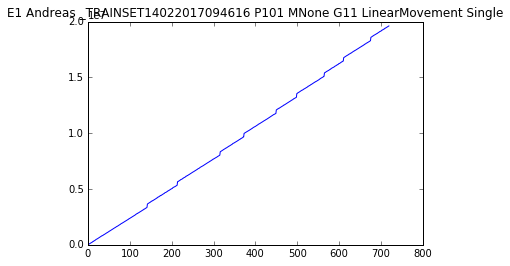

In [126]:
one_plot(mydata,'TimeStamp')

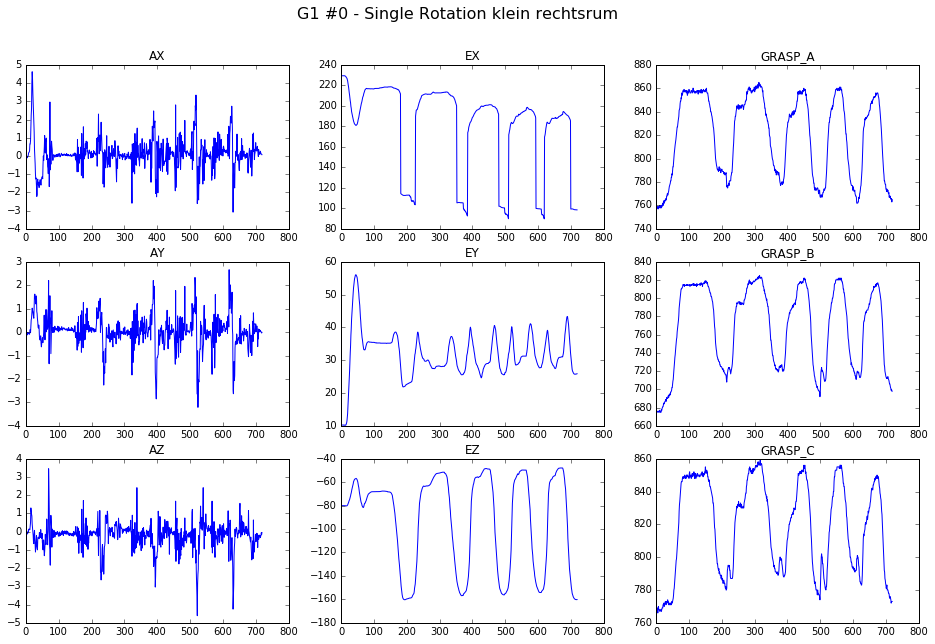

In [127]:
title = "G%d #%d - %s" % (g,i,gesture_name(g))
grid_plot(mydata, title)

In [128]:
# get 3rd entry fo gesture 3
g = 3
i=3
mydata = gesture_exp_dict[g][i]

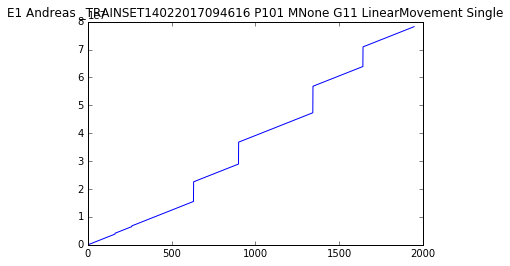

In [129]:
one_plot(mydata,'TimeStamp')

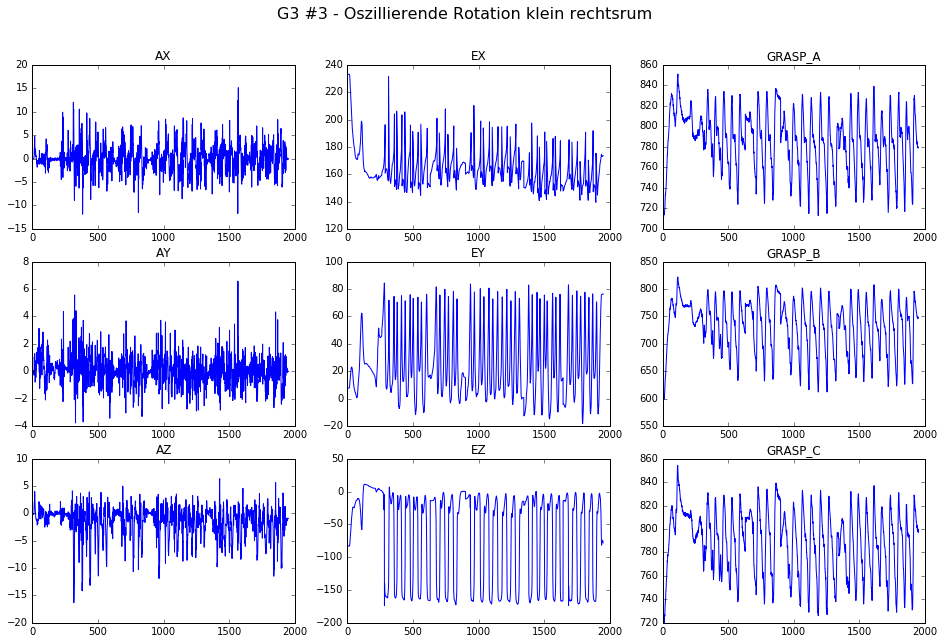

In [130]:
title = "G%d #%d - %s" % (g,i,gesture_name(g))
grid_plot(mydata, title)

In [131]:
g = 4
i=2
mydata = gesture_exp_dict[g][i]

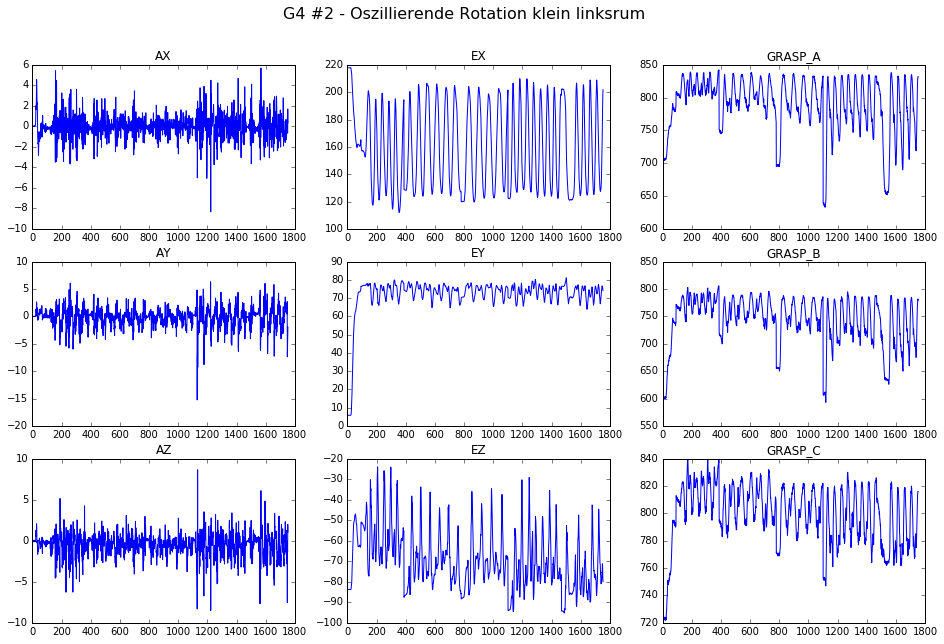

In [132]:
title = "G%d #%d - %s" % (g,i,gesture_name(g))
grid_plot(mydata, title)

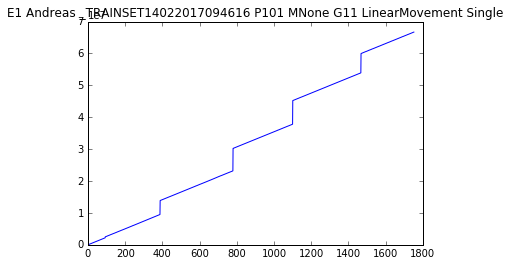

In [133]:
one_plot(mydata,'TimeStamp')

## TODO why do we still have step data here??

## Preparation of Data 
### for Analysis: Reduce data to desired parameter columns

In [134]:
# in the group_df iteration before, we kept all data columns 
# now we ITERATE over the gesture_exp_dict again, retaining only the parameter columns

gesture_dict_params = {}
n_datablocks = 0

for g in sorted(gesture_exp_dict.keys()):
    print "G" + str(g) +'\t',
        
    #initalize empty list for this gesture
    gesture_dict_params[g] = [] 
            
    for datablock in gesture_exp_dict[g]:

        # reduce to params columns
        datablock_params = datablock[params] # .T # prevously: # transpose: 9 data rows with params, cols is time series
        
        # add data to new gesture dict
        gesture_dict_params[g].append(datablock_params)
        
        n_datablocks += 1
    
    print len(gesture_dict_params[g]), "data blocks"
print

G1	120 data blocks
G2	120 data blocks
G3	81 data blocks
G4	81 data blocks
G5	60 data blocks
G6	60 data blocks
G7	20 data blocks
G8	20 data blocks
G9	20 data blocks
G10	20 data blocks
G11	66 data blocks
G12	32 data blocks
G13	20 data blocks



### Testing Scale Normalization: Min-Max Scaling

#### Test for 1 signal

In [135]:
# get 0th entry fo gesture 1
g = 1
i=0
mydata = gesture_dict_params[g][i]
var = 'EZ'
signal_orig = mydata[var]

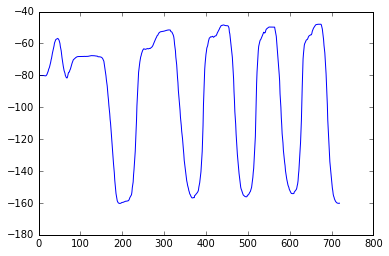

In [136]:
# plot with indices on x
y = signal_orig
plt.plot(range(len(y)), y)

In [137]:
# normalize to -1, 1
signal_normalized = preprocessing.minmax_scale(signal_orig, feature_range=(-1, 1))

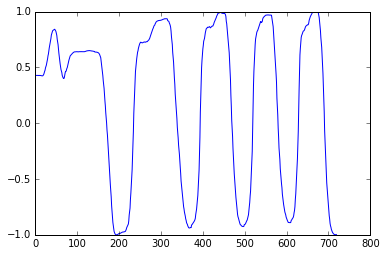

In [138]:
# plot with indices on x
y = signal_normalized
plt.plot(range(len(y)), y)

#### Test for all signals

In [139]:
# try on a block of data
mydata.head()

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
133609,0.07,-0.05,0.04,229.3125,10.25,-80.0625,759,677,768
133611,0.03,-0.05,0.08,229.3125,10.25,-80.0625,758,676,768
133613,-0.03,-0.08,-0.02,229.2500,10.25,-80.0625,758,675,767
133615,-0.09,-0.13,-0.02,229.2500,10.25,-80.0625,758,676,767
133618,-0.10,-0.10,-0.13,229.2500,10.25,-80.0625,759,676,769


In [140]:
# normalize all rows
mydata_norm = preprocessing.minmax_scale(mydata, feature_range=(-1, 1),axis=0)
mydata_norm.shape

(720, 9)

In [141]:
mydata_norm = pd.DataFrame(mydata_norm, index=mydata.index, columns=mydata.columns)
mydata_norm.head()

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
133609,-0.181818,0.076661,0.153846,0.999104,-0.997271,0.428254,-0.962963,-0.973333,-0.956989
133611,-0.192208,0.076661,0.163772,0.999104,-0.997271,0.428254,-0.981481,-0.986667,-0.956989
133613,-0.207792,0.066440,0.138958,0.998209,-0.997271,0.428254,-0.981481,-1.000000,-0.978495
133615,-0.223377,0.049404,0.138958,0.998209,-0.997271,0.428254,-0.981481,-0.986667,-0.978495
133618,-0.225974,0.059625,0.111663,0.998209,-0.997271,0.428254,-0.962963,-0.986667,-0.935484


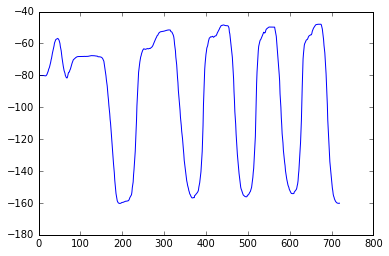

In [142]:
# before
var = 'EZ'
y = mydata[var]
plt.plot(range(len(y)), y)

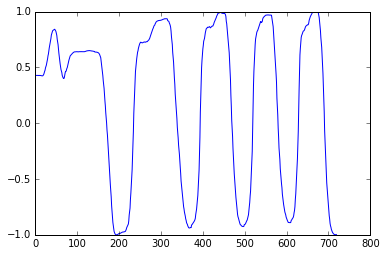

In [143]:
# plot with indices on x
y = mydata_norm[var]
plt.plot(range(len(y)), y)

### Doing Scale Normalization: Min-Max Scaling

In [144]:
make_copy = True  # MAKE A COPY OF THE DATA for normalized version -> takes more RAM

In [145]:
# Loop over ALL gesture data
# build new gesture dictionary for normalized data

gesture_dict_norm = {}

for g in sorted(gesture_dict_params.keys()):
    print "G" + str(g) +'\t',

    #initalize empty list for this gesture
    gesture_dict_norm[g] = [] 

    for datablock in gesture_dict_params[g]:

        # normalize all param columns
        datablock_norm = preprocessing.minmax_scale(datablock, feature_range=(-1, 1), axis=0, copy=make_copy)
        
        # make DataFrame again (to retriev column parameters later)
        datablock_norm = pd.DataFrame(datablock_norm, index=datablock.index, columns=datablock.columns)

        # add data to new gesture dict
        gesture_dict_norm[g].append(datablock_norm)

    print len(gesture_dict_norm[g]), "data blocks"

G1	120 data blocks
G2	120 data blocks
G3	81 data blocks
G4	81 data blocks
G5	60 data blocks
G6	60 data blocks
G7	20 data blocks
G8	20 data blocks
G9	20 data blocks
G10	20 data blocks
G11	66 data blocks
G12	32 data blocks
G13	20 data blocks


In [146]:
# Verifying normalization

In [147]:
# get 0th entry fo gesture 1
g = 1
i=0
mydata = gesture_dict_norm[g][i]
mydata.head()

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
133609,-0.181818,0.076661,0.153846,0.999104,-0.997271,0.428254,-0.962963,-0.973333,-0.956989
133611,-0.192208,0.076661,0.163772,0.999104,-0.997271,0.428254,-0.981481,-0.986667,-0.956989
133613,-0.207792,0.066440,0.138958,0.998209,-0.997271,0.428254,-0.981481,-1.000000,-0.978495
133615,-0.223377,0.049404,0.138958,0.998209,-0.997271,0.428254,-0.981481,-0.986667,-0.978495
133618,-0.225974,0.059625,0.111663,0.998209,-0.997271,0.428254,-0.962963,-0.986667,-0.935484


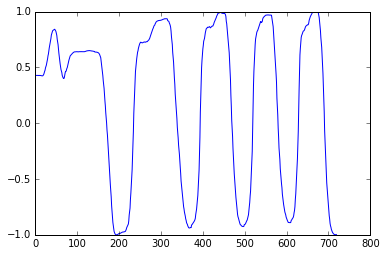

In [148]:
var = 'EZ'
y = mydata[var]
plt.plot(range(len(y)), y)

### Testing Time Normalization: Resampling

In [149]:
from scipy.signal import resample

In [150]:
# Time Normalize / Interpolate time stamps
signal_orig = gesture_exp_dict[g][i]['EZ']
signal_orig_timestamps = gesture_exp_dict[g][i]['TimeStamp'].values

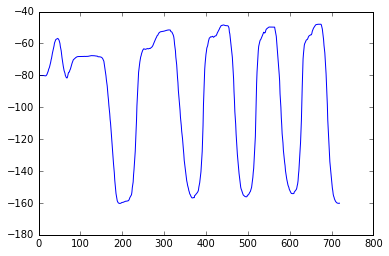

In [151]:
# plot with indices on x
y = signal_orig
plt.plot(range(len(y)), y)

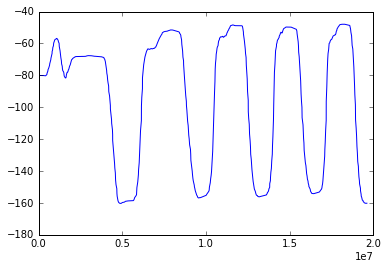

In [152]:
# plot with timestamps on x
plt.plot(signal_orig_timestamps, signal_orig)

In [153]:
signal_orig_timestamps

array([       0,    24915,    49032,    74016,   111220,   122772,
         143717,   172480,   186423,   211319,   237536,   261141,
         302690,   305197,   341003,   358648,   378704,   408709,
         429957,   465009,   496254,   507459,   528727,   552519,
         569787,   600022,   618599,   656084,   666187,   691414,
         729973,   739742,   776164,   806392,   809896,   837552,
         851211,   887364,   902347,   927484,   950216,   972477,
         998682,  1021211,  1058688,  1068642,  1092615,  1114904,
        1139853,  1167723,  1187699,  1226048,  1236494,  1261090,
        1282302,  1307214,  1331441,  1361090,  1376138,  1412380,
        1423673,  1446146,  1492381,  1511288,  1525977,  1542202,
        1574814,  1596047,  1623634,  1647392,  1657443,  1684885,
        1708685,  1733904,  1758645,  1781044,  1806245,  1829947,
        1851115,  1891083,  1914946,  1925103,  1948645,  1971196,
        1997442,  2018621,  2033605,  2058657,  2083561,  2109

In [154]:
# testing
#samples = 500 

# we set number of samples in resample signal to average number of samples across all gestures
samples = avg_data_len

# TODO: try max of sample length of all gestures

# If t is not given, it is assumed to be the sample positions associated with the signal data in x.
signal_resampled = resample(signal_orig, num=samples) # , t=None,

In [155]:
signal_resampled2, timestamps2 = resample(signal_orig, num=samples, t=signal_orig_timestamps)

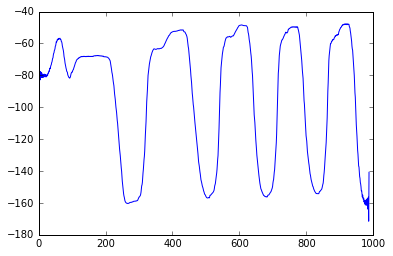

In [156]:
# plot with indices on x
y = signal_resampled
plt.plot(range(len(y)), y)

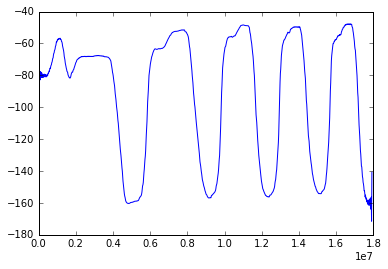

In [157]:
# plot with timestamps on x
y = signal_resampled2
plt.plot(timestamps2, y)

### Resampling / Time Normalization - Batch

In [158]:
use_normalized_for_resampling = True

In [159]:
if use_normalized_for_resampling:
    # normalized
    input_dict = gesture_dict_norm
else:
    # original
    input_dict = gesture_dict_params

In [160]:
# Resample Loop over ALL data

# build new gesture dictionary for resampled data

gesture_dict_resampled = {}

for g in sorted(input_dict.keys()):
    print "G", g#, ':\t'#, 
    gesture_dict_resampled[g] = [] # initalize empty list for this gesture
    
    for datablock in input_dict[g]:
        #print datablock.shape, 

        # resample the whole block, along cols (axis = 1), to target num samples
        datablock_resampled = resample(datablock, num=samples, axis=0)
        
        # make DataFrame again (to retriev column parameters later)
        datablock_resampled = pd.DataFrame(datablock_resampled, columns=datablock.columns)

        # add data to new gesture dict
        gesture_dict_resampled[g].append(datablock_resampled)
    #print

G 1
G 2
G 3
G 4
G 5
G 6
G 7
G 8
G 9
G 10
G 11
G 12
G 13


### Verification

In [161]:
datablock.shape

(848, 9)

In [162]:
# get 0th entry fo gesture 1
g = 1
i=0
mydata = input_dict[g][i]
mydata.head()

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
133609,-0.181818,0.076661,0.153846,0.999104,-0.997271,0.428254,-0.962963,-0.973333,-0.956989
133611,-0.192208,0.076661,0.163772,0.999104,-0.997271,0.428254,-0.981481,-0.986667,-0.956989
133613,-0.207792,0.066440,0.138958,0.998209,-0.997271,0.428254,-0.981481,-1.000000,-0.978495
133615,-0.223377,0.049404,0.138958,0.998209,-0.997271,0.428254,-0.981481,-0.986667,-0.978495
133618,-0.225974,0.059625,0.111663,0.998209,-0.997271,0.428254,-0.962963,-0.986667,-0.935484


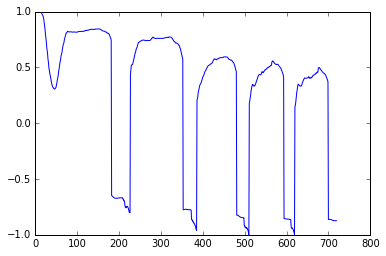

In [163]:
# before
var = 'EX'
y = mydata[var]
plt.plot(range(len(y)), y)

In [164]:
# after
mydata_res = gesture_dict_resampled[g][i]
mydata_res.head()

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
0,-0.181818,0.076661,0.153846,0.999104,-0.997271,0.428254,-0.962963,-0.973333,-0.956989
1,-0.196633,0.064063,0.161258,1.157106,-1.057309,0.551957,-0.996273,-1.008747,-0.967912
2,-0.188412,0.089394,0.156728,0.862222,-0.944367,0.319927,-0.964187,-0.970620,-0.951538
3,-0.216826,0.055122,0.135743,1.054024,-1.019347,0.473177,-0.990194,-1.009832,-0.989329
4,-0.225146,0.046844,0.139106,1.019154,-1.005700,0.445300,-0.985653,-0.992202,-0.984472


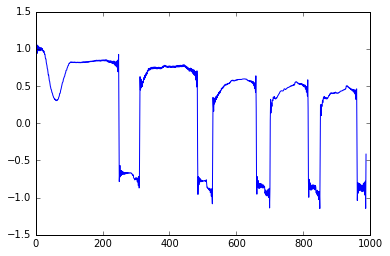

In [165]:
y = mydata_res[var]
plt.plot(range(len(y)), y)

### Testing: Calc Derivative Signals

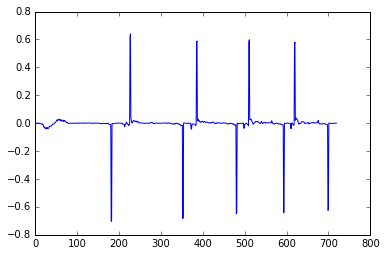

In [166]:
# Calc derivatives 

v = 'EX'
y = mydata[var]

y_d = np.gradient(y) 
plt.plot(range(len(y_d)), y_d)

In [167]:
# can we do it on the matrix of input signals?
mydata_deriv = np.gradient(mydata, axis=0)
mydata_deriv.shape

(720, 9)

In [168]:
# deriv from full matrix
i = mydata.columns.get_loc(var)
i

3

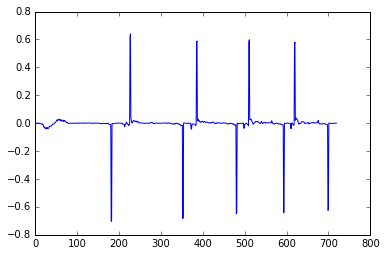

In [169]:
y = mydata_deriv[:,i]
plt.plot(range(len(y)), y)

#### -> Problem with Artefacts!

### Testing Zero Crossing Rate

In [170]:
# Zero-Crossing rate measures how often the signal changes its sign from positive to negative or vice-versa
# Matlab code: ZCR=mean(abs(diff(sign(Signal)))

In [171]:
def signal_one_plot(mydata,var):
    y = mydata[var]
    x = range(len(y))
    #x = mydata['TimeStamp']
    plt.plot(x, y)
    title = var
    plt.title(title)
    #plt.show()

In [172]:
# TESTING: 
# reusing mydata from above
mydata.head()

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
133609,-0.181818,0.076661,0.153846,0.999104,-0.997271,0.428254,-0.962963,-0.973333,-0.956989
133611,-0.192208,0.076661,0.163772,0.999104,-0.997271,0.428254,-0.981481,-0.986667,-0.956989
133613,-0.207792,0.066440,0.138958,0.998209,-0.997271,0.428254,-0.981481,-1.000000,-0.978495
133615,-0.223377,0.049404,0.138958,0.998209,-0.997271,0.428254,-0.981481,-0.986667,-0.978495
133618,-0.225974,0.059625,0.111663,0.998209,-0.997271,0.428254,-0.962963,-0.986667,-0.935484


In [173]:
var = 'AX'

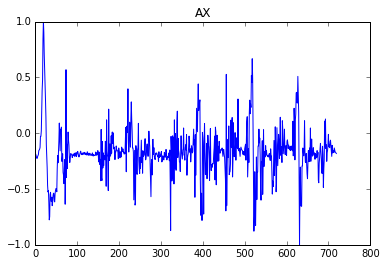

In [174]:
signal_one_plot(mydata,var)

In [175]:
# TEST with 1 signal
signal = mydata[var]

In [176]:
# NOTE: np.sign vs. np.signbit do not use sign function cause it can be -1 , 0 or 1 and then diff is 2
# instead we use np.signbit which is False or Ture (when the sign of the signal changes)
# this is what we want to count for ZCR
# testint the difference:
#np.sign(signal)
#np.signbit(signal)

In [177]:
# ZCR calculation
# ZCR=mean(abs(diff(sign(Signal))) # Matlab code

# for 1 signal row:
zcr = np.signbit(signal).diff().abs().mean()
zcr

0.13351877607788595

In [178]:
# for multiple signal rows:
zcr = np.signbit(mydata).astype(int).diff(axis=0).abs().mean(axis=0)
zcr

AX         0.133519
AY         0.164117
AZ         0.200278
EX         0.012517
EY         0.025035
EZ         0.012517
GRASP_A    0.013908
GRASP_B    0.013908
GRASP_C    0.013908
dtype: float64

### Zero Crossing Rate - Implementation

In [179]:
def calc_zero_crossings(datablock):
    '''computes row-wise zerocrossings'''
    # datablock is assumed to be pandas Dataframe and to have multiple signals in the rows
    # example for 1 signal row:
    #zcr = np.signbit(signal).diff().abs().mean()
    # for multiple signal rows:
    return np.signbit(datablock).astype(int).diff(axis=0).abs().mean(axis=0)

###  Add more features?

## Feature Calculation

#### Statistical Features, Derivative, Zero Crossings

#### Options: Set Options here

In [180]:
# OPTIONS:

# either/or:
use_normalized = True 
use_resampled = True 
# if both are False, unresampled unnormalized input is used

# other options: # True is better for all
exclude_non_gestures = True
calc_derivative = True
calc_zerocrossings = True

In [181]:
# Calc statistical features

def calc_statistical_features(matrix, axis=0):

    # to define the proper output shape, we need the "other axis" of the input shape (not the one where we compute along)
    other_axis = int(not axis) 
    n_rows = matrix.shape[other_axis]
    
    result = np.zeros((n_rows,7))
    
    result[:,0] = np.mean(matrix, axis=axis)
    result[:,1] = np.var(matrix, axis=axis, dtype=np.float64) 
    result[:,2] = stats.skew(matrix, axis=axis)
    result[:,3] = np.median(matrix, axis=axis)
    result[:,4] = np.min(matrix, axis=axis)
    result[:,5] = np.max(matrix, axis=axis)
    result[:,6] = stats.kurtosis(matrix, axis=axis, fisher=False) # Matlab calculates Pearson's Kurtosis

    result[np.where(np.isnan(result))] = 0
    return result

In [182]:
if use_resampled:
    input_dict = gesture_dict_resampled 
elif use_normalized:
    input_dict = gesture_dict_norm
else:
    input_dict = gesture_dict_params # non resampled

if exclude_non_gestures:
    gestures_to_process = gestures_pos
else:
    gestures_to_process = input_dict.keys()

In [183]:
# LOOP over all gesture data to create features

# initialize feature output for training data as a list
train_list = []
train_classes_num = []

for gest in sorted(gestures_to_process):
    print "G", gest, ':\t', len(input_dict[gest]), "examples"
    
    for in_data in input_dict[gest]:
        #print datablock.shape, 
        
        #if use_resampled:
        #    # resampled data has already extracted the param columns
        #    in_data = datablock
        #else:
        #    # for non-resampled we have to get the relevant data columns and transpose
        #    in_data = datablock[params].T

        # calc statistical features
        features = calc_statistical_features(in_data, axis=0)
        #features.shape
 
        # vectorize
        features = features.flatten()
        
        if calc_derivative:
            # calc derivative of all signals
            in_data_deriv = np.gradient(in_data, axis=0)
            # calc statistics of derivatives
            features_deriv = calc_statistical_features(in_data_deriv, axis=0)
            # vectorize
            features_deriv = features_deriv.flatten()
            # concatenate to other features
            features = np.concatenate((features,features_deriv))
            
        if calc_zerocrossings:
            features_zcr = calc_zero_crossings(in_data)
            features = np.concatenate((features,features_zcr))
        
        # append to output
        train_list.append(features)
        
        # store class for these features
        train_classes_num.append(gest)
        
        
    #print

G 1 :	120 examples
G 2 :	120 examples
G 3 :	81 examples
G 4 :	81 examples
G 5 :	60 examples
G 6 :	60 examples
G 7 :	20 examples
G 8 :	20 examples
G 9 :	20 examples
G 10 :	20 examples
G 11 :	66 examples
G 12 :	32 examples
G 13 :	20 examples


In [184]:
features.shape

(135,)

## Prepare Training Data

In [185]:
print "Training data:", len(train_list), "examples"

Training data: 720 examples


In [186]:
# make feature array from feature list (ALL training data)

train_data = np.array(train_list)
#del train_list
train_data.shape

(720, 135)

In [187]:
# verify if the training categories (gesture numbers) have the same length
len(train_classes_num)

720

### Standardize

In [188]:
# Zero-mean unit-variance Standardization
train_data = preprocessing.scale(train_data,axis=0)
# axis=0 means independently standardize each feature, otherwise (if 1) standardize each sample

## Machine Learning

### Train/Test Set Split

In [189]:
# split the data into train/test set

testset_size = 0.25

# sklearn >= 0.18
# use random_state to avoid that the results fluctuate randomly
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0) 
splits = splitter.split(train_data, train_classes_num)

# Note: this for loop is only executed once, if n_splits==1
for train_index, test_index in splits:
    #print "TRAIN INDEX:", train_index
    #print "TEST INDEX:", test_index
    
    # split the data
    train_set = train_data[train_index]
    test_set = train_data[test_index]
    
    # and the numeric classes (groundtruth)
    train_classes = np.array(train_classes_num)[train_index]
    test_classes = np.array(train_classes_num)[test_index]
    
    print "TRAIN SIZE:", train_set.shape
    print "TEST SIZE:", test_set.shape
    

TRAIN SIZE: (540, 135)
TEST SIZE: (180, 135)


## Tasks

### Recognize Gesture (independent of host)

## ML Algorithm 1: SVM

Support Vector Machines

In [190]:
# try 3 different SVM kernels
kernels = ['linear','poly','rbf']

In [191]:
models = {}

for kernel in kernels:
    print "SVM", kernel,
    
    # TRAIN 
    start_time = time.time() # measure time

    model = OneVsRestClassifier(SVC(kernel=kernel)) #, degree=degree)) #, n_jobs=-1)  # n_jobs = n cpus, -1 = all
    # full set
    #model.fit(train_data, train_classes_num)
    # train set
    model.fit(train_set, train_classes)
    
    # store in dict
    models[kernel] = model

    end_time = time.time()
    print "Training time:", timestr(end_time - start_time)

SVM linear Training time: 0:00:00
SVM poly Training time: 0:00:00
SVM rbf Training time: 0:00:00


#### Verification on Train Set (just for plausibility)

In [192]:
# predict on train set
pred_train = model.predict(train_set)
pred_train

array([ 6,  2,  1,  5,  9,  4, 10,  1,  5, 11,  3, 12,  4,  7, 12, 12,  2,
        2,  1,  1,  1,  6,  1,  6,  3, 11, 12,  3,  2,  4,  4,  1,  1,  9,
        4,  1,  1, 11, 11,  1, 11, 13,  4,  1,  2,  4,  2,  8,  6,  4, 10,
        6,  9,  5,  4,  5, 11,  7,  1,  5,  8,  3, 11,  6,  3, 11,  6, 11,
        6, 13,  1, 11,  3,  1, 11,  1, 11, 13,  5, 13,  3,  3,  1,  6,  1,
        1,  2,  8, 12,  2,  1,  2, 12,  1,  2,  3,  3,  4,  1, 10,  6, 11,
        2,  1,  4,  2, 11,  2,  2,  1,  5,  6,  3, 11,  6,  3,  1,  5, 12,
        9,  2,  1,  1,  2,  3,  2,  2,  4, 11,  2,  6,  4,  1, 11,  9,  1,
       12,  2,  8,  6,  1,  1, 11,  7, 11, 12,  5,  6, 11,  3,  1, 12, 10,
        3,  3,  2,  3,  5, 13,  4,  4,  4,  1,  2,  2,  6,  3,  5, 10,  5,
        2,  1,  1, 13, 11,  2, 12,  5,  1,  3, 11, 10, 11,  5,  6,  5,  3,
        1,  4,  3,  5,  6, 10,  4,  5,  3,  1,  9, 11,  2,  8,  6,  4,  3,
       11,  6,  6, 11,  2, 11,  4,  1,  1,  4,  2,  2, 12, 11,  9,  2,  7,
        6,  3, 11,  1,  1

In [193]:
train_classes

array([ 6,  2,  1,  5,  9,  4, 10,  1,  5, 11,  3, 12,  4,  7, 12, 12,  1,
        2,  1,  1,  1,  5,  1,  6,  3, 11, 12,  3,  2,  4,  4,  1,  1,  9,
        4,  1,  1, 11, 11,  1, 11, 13,  4,  1,  2,  4,  2,  8,  6,  4, 10,
        6,  9,  5,  4,  5, 11,  7,  1,  5,  8,  3, 11,  6,  3, 11,  6, 11,
        6, 13,  1, 11,  3,  1, 11,  1, 11, 13,  5, 13,  3,  3,  1,  6,  1,
        1,  2,  8, 12,  2,  1,  2, 12,  1,  2,  3,  3,  4,  1, 10,  6, 11,
        2,  1,  4,  2, 11,  2,  2,  1,  5,  6,  3, 11,  6,  3,  1,  5, 12,
        9,  2,  1,  1,  2,  3,  2,  2,  4, 11,  2,  6,  4,  1, 11,  9,  1,
       12,  2,  8,  6,  1,  1, 11,  7, 11, 12,  5,  6, 11,  3,  1, 12, 10,
        3,  3,  2,  3,  5, 13,  4,  4,  4,  1,  2,  2,  6,  3,  5, 10,  5,
        2,  1,  1, 13, 11,  2, 12,  5,  1,  3, 11, 10, 11,  5,  6,  5,  3,
        1,  4,  3,  5,  6, 10,  4,  5,  3,  1,  9, 11,  2,  8,  6,  4,  3,
       11,  6,  6, 11,  2, 11,  4,  1,  1,  4,  2,  2, 12, 11,  9,  2,  7,
        1,  3, 11,  1,  1

In [194]:
# Accuracy on train set (manual computation)
np.sum(pred_train == train_classes) * 1.0 / len(train_classes)

0.98703703703703705

In [195]:
# Accuracy on train set (using scikit-learn)
accuracy_score(train_classes, pred_train)

0.98703703703703705

## Evaluation

### Evaluation - Overall

In [196]:
result_ov = pd.DataFrame(index=kernels, columns=['Accuracy','Precision','Recall','F-Measure'])

In [197]:
for k in kernels:
    # predict on TEST set
    pred_test = models[k].predict(test_set) 
    
    # Accuracy, Precision, Reacall on TEST set
    result_ov.loc[k,'Accuracy'] = accuracy_score(test_classes, pred_test)
    result_ov.loc[k,'Precision'] = precision_score(test_classes, pred_test, average='macro')
    result_ov.loc[k,'Recall'] = recall_score(test_classes, pred_test, average='macro')
    result_ov.loc[k,'F-Measure'] = f1_score(test_classes, pred_test, average='macro')

In [198]:
pd.options.display.float_format = '{:,.2f}'.format

In [199]:
result_ov*100

,Accuracy,Precision,Recall,F-Measure
linear,70.00,74.94,72.49,73.09
poly,81.11,85.64,87.37,85.88
rbf,81.11,83.39,87.88,84.74


### Evaluation - Per Gesture

In [200]:
# manual selection which one was the best one
best_model = models['poly']
pred_test = best_model.predict(test_set) 

In [201]:
# TODO check if the sorting of precision_score etc. is really in this order!!
labels = sorted(np.unique(test_classes))
gesture_names = [gesture_name(l) for l in labels]

In [202]:
# nice result dataframe
columns = ['Gesture','N_train','N_test','Precision','Recall','F1']
result_df = pd.DataFrame(index=labels,columns=columns)
result_df['Gesture'] = gesture_names

In [203]:
# number of train / test instances
values, counts = np.unique(train_classes, return_counts=True)
result_df['N_train'] = pd.Series(counts, index=values)
values, counts = np.unique(test_classes, return_counts=True)
result_df['N_test'] = pd.Series(counts, index=values)

In [204]:
# per class evaluation
result_df['Precision'] = precision_score(test_classes, pred_test, average=None) * 100
result_df['Recall'] = recall_score(test_classes, pred_test, average=None) * 100
result_df['F1'] = f1_score(test_classes, pred_test, average=None) * 100

In [205]:
result_df

,Gesture,N_train,N_test,Precision,Recall,F1
1,Single Rotation klein rechtsrum,90,30,70.97,73.33,72.13
2,Single Rotation klein linksrum,90,30,78.26,60.00,67.92
3,Oszillierende Rotation klein rechtsrum,61,20,83.33,75.00,78.95
4,Oszillierende Rotation klein linksrum,61,20,86.96,100.00,93.02
5,Single Rotation groß rechtsrum,45,15,92.86,86.67,89.66
6,Single Rotation groß linksrum,45,15,90.91,66.67,76.92
7,Oszillierende Rotation groß rechtsrum,15,5,100.00,100.00,100.00
8,Oszillierende Rotation groß linksrum,15,5,80.00,80.00,80.00
9,Kontinuierliche Rotation groß rechtsrum,15,5,100.00,100.00,100.00
10,Kontinuierliche Rotation groß linksrum,15,5,83.33,100.00,90.91


In [206]:
result_df.mean(axis=0)

N_train     41.54
N_test      13.85
Precision   85.64
Recall      87.37
F1          85.88
dtype: float64

In [207]:
# For Information: Number of train/test samples per each gesture
result_df2 = result_df.loc[:,('Gesture','N_train','N_test')]
result_df2['N'] = result_df2['N_train'] + result_df2['N_test']  
result_df2

,Gesture,N_train,N_test,N
1,Single Rotation klein rechtsrum,90,30,120
2,Single Rotation klein linksrum,90,30,120
3,Oszillierende Rotation klein rechtsrum,61,20,81
4,Oszillierende Rotation klein linksrum,61,20,81
5,Single Rotation groß rechtsrum,45,15,60
6,Single Rotation groß linksrum,45,15,60
7,Oszillierende Rotation groß rechtsrum,15,5,20
8,Oszillierende Rotation groß linksrum,15,5,20
9,Kontinuierliche Rotation groß rechtsrum,15,5,20
10,Kontinuierliche Rotation groß linksrum,15,5,20


In [208]:
# Confusion Matrix
conf = confusion_matrix(test_classes, pred_test, labels=labels) # labels defines the order

In [209]:
conf_df = pd.DataFrame(conf, index=labels, columns=labels)
conf_df

,1,2,3,4,5,6,7,8,9,10,11,12,13
1,22,3,1,0,1,0,0,0,0,0,3,0,0
2,7,18,2,0,0,1,0,0,0,1,1,0,0
3,1,0,15,2,0,0,0,1,0,0,0,1,0
4,0,0,0,20,0,0,0,0,0,0,0,0,0
5,0,1,0,0,13,0,0,0,0,0,1,0,0
6,1,1,0,0,0,10,0,0,0,0,3,0,0
7,0,0,0,0,0,0,5,0,0,0,0,0,0
8,0,0,0,1,0,0,0,4,0,0,0,0,0
9,0,0,0,0,0,0,0,0,5,0,0,0,0
10,0,0,0,0,0,0,0,0,0,5,0,0,0


## Time Series Prediction

What is our input stream?

The data of 1 trainset, because after each trainset, the TimeStamp is reset.

In [216]:
group_by = ('Subject','Experiment','Trainset')
group_df = data.groupby(group_by)
group_df.max().head(50) 

TimeStamp          RFID  GRASP_A  \
Subject Experiment Trainset                                                    
Alfred  2          _TRAINSET14022017144824   19612564  000000000000      865   
                   _TRAINSET14022017144923   15223230  09006734114B      863   
                   _TRAINSET14022017145122   20921978  09006734114B      859   
                   _TRAINSET14022017145237   23100693  09006734114B      872   
                   _TRAINSET14022017145434   16454910  09006734114B      832   
                   _TRAINSET14022017145514   14960194  09006734114B      846   
                   _TRAINSET14022017145629   15360544  000000000000      854   
                   _TRAINSET14022017145751   19788136  09006734114B      869   
                   _TRAINSET14022017145913   15783252  000000000000      848   
                   _TRAINSET14022017145944   15417818  000000000000      848   
                   _TRAINSET14022017150026   17553946  000000000000      854   
                   _TRAINSET14022017150110   21570747  09006734114B      857   
                   _TRAINSET14022017150614   24466757  000000000000      848   
                   _TRAINSET14022017150702   21253124  000000000000      844   
                   _TRAINSET14022017150748   28236229  13005E4BB7B1      853   
                   _TRAINSET14022017151539   24969463  000000000000      854   
                   _TRAINSET14022017151631   22410682  000000000000      856   
                   _TRAINSET14022017151826   21074589  000000000000      847   
                   _TRAINSET14022017151945   21837128  000000000000      857   
                   _TRAINSET14022017152030   22047159  000000000000      869   
                   _TRAINSET14022017152128   21228119  000000000000      871   
                   _TRAINSET14022017152424   21654808  000000000000      850   
                   _TRAINSET14022017152511   21119499  000000000000      856   
                   _TRAINSET14022017152553   21085877  000000000000      850   
                   _TRAINSET14022017152806   17813175  000000000000      847   
                   _TRAINSET14022017152849   18592281  000000000000      853   
                   _TRAINSET14022017153027   19732786  000000000000      850   
                   _TRAINSET14022017153200   18957203  000000000000      864   
                   _TRAINSET14022017153244   19193997  000000000000      860   
                   _TRAINSET14022017153321   19762104  000000000000      864   
                   _TRAINSET14022017153429   17026754  000000000000      869   
                   _TRAINSET14022017153506   19194050  000000000000      880   
                   _TRAINSET14022017153600   21152405  000000000000      876   
                   _TRAINSET14022017155335   32325281  05003DD5CD20      862   
                   _TRAINSET14022017155638   20149362  05003DD5CD20      865   
                   _TRAINSET14022017155725   18854673  05003DD5CD20      862   
                   _TRAINSET14022017155851   20374166  05003DD5CD20      856   
                   _TRAINSET14022017155941   18676898  05003DD5CD20      852   
                   _TRAINSET14022017160118   17510704  05003DD5CD20      859   
                   _TRAINSET14022017160156   17851177  05003DD5CD20      858   
                   _TRAINSET14022017160236   19894847  05003DD5CD20      854   
                   _TRAINSET14022017160314   18662659  05003DD5CD20      856   
                   _TRAINSET14022017160657   28414687  760057911BAB      857   
                   _TRAINSET14022017160826   26911698  760057911BAB      852   
                   _TRAINSET14022017160921   25486004  760057911BAB      852   
                   _TRAINSET14022017161007   26696321  760057911BAB      848   
                   _TRAINSET14022017161057   25855014  760057911BAB      838   
                   _TRAINSET14022017161236   44132577  760057911BAB      834   
                   _TRAINSET14022017161713  

In [218]:
print len(group_df), "Trainsets"

539 Trainsets


In [221]:
# iterate over each Trainset
i =0
for name_tuple, group_data in group_df:
    i += 1
    #print str(name_tuple)
    subject, exp, trainset = name_tuple
    
    break # for testing we just do 1 loop
    

In [227]:
group_data['TimeStamp'].min()

0

In [228]:
group_data['TimeStamp'].max()

19612564

In [232]:
# check if TimeStamps are monotonously increasing
if not np.all(group_data['TimeStamp'].diff()[1:] > 0):
    raise ValueError("Time Stamps are not monotonously increasing!")

In [241]:
# set these to None so that plot title is not shown wrongly
parcours = None
mutation = None
gesture = None

In [243]:
# which gestures appear in this trainset
group_data['Gesture'].unique()

array([1])

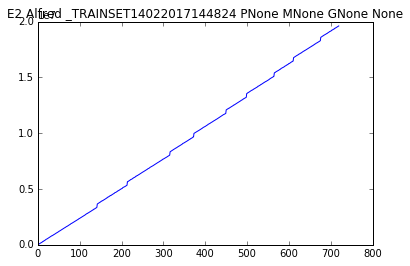

In [244]:
one_plot(group_data,'TimeStamp')

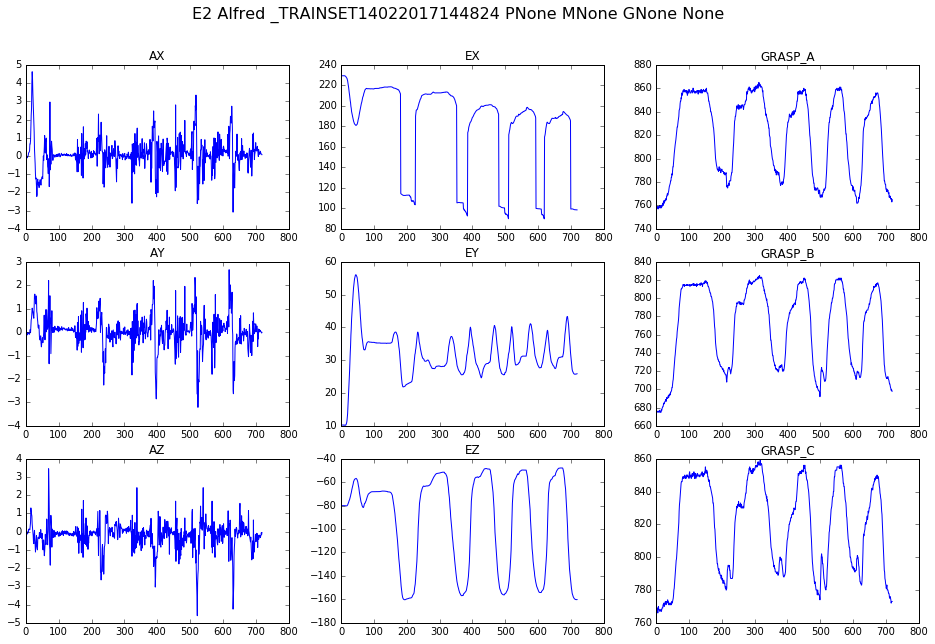

In [240]:
grid_plot(group_data)

### Pre-Process the Data

the same way as it was done for training set

In [294]:
pd.options.display.float_format = '{:,.5f}'.format

In [304]:
# reduce to 9 parameters columns
testdata = group_data[params]
testdata.shape

(720, 9)

In [305]:
timestamps = group_data['TimeStamp'].tolist()

In [306]:
# min/max normalization
# TODO: store minmax_scale from training data and reapply same scaling here

# if...

testdata = preprocessing.minmax_scale(testdata, feature_range=(-1, 1), axis=0, copy=make_copy)

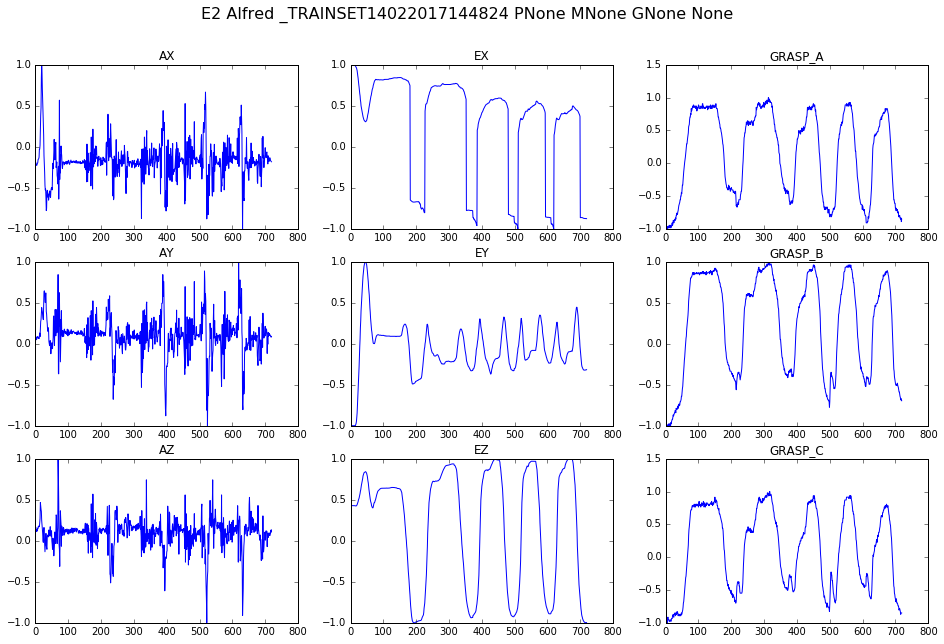

In [307]:
# convert to dataframe cause plot needs column names
testdata = pd.DataFrame(testdata, columns=params)
grid_plot(testdata)

In [308]:
testdata.head(15)

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
0,-0.18182,0.07666,0.15385,0.99910,-0.99727,0.42825,-0.96296,-0.97333,-0.95699
1,-0.19221,0.07666,0.16377,0.99910,-0.99727,0.42825,-0.98148,-0.98667,-0.95699
2,-0.20779,0.06644,0.13896,0.99821,-0.99727,0.42825,-0.98148,-1.00000,-0.97849
3,-0.22338,0.04940,0.13896,0.99821,-0.99727,0.42825,-0.98148,-0.98667,-0.97849
4,-0.22597,0.05963,0.11166,0.99821,-0.99727,0.42825,-0.96296,-0.98667,-0.93548
5,-0.21039,0.08688,0.13400,0.99821,-0.99727,0.42825,-0.98148,-1.00000,-1.00000
6,-0.20000,0.07325,0.12407,0.99821,-0.99727,0.42825,-1.00000,-1.00000,-0.93548
7,-0.19221,0.08348,0.15385,0.99910,-0.99727,0.42825,-0.96296,-0.98667,-0.91398
8,-0.15584,0.08348,0.15136,1.00000,-0.99727,0.42714,-0.96296,-0.98667,-0.95699
9,-0.15065,0.06644,0.17866,1.00000,-1.00000,0.42714,-0.98148,-1.00000,-0.95699


In [309]:
# time resample

# if...

n_samples = len(timestamps)  # the number of samples stays the same

# but we use the original timestamps to re-align the signal
testdata_res, timestamps2 = resample(testdata, num=n_samples, t=timestamps)

In [310]:
# convert to dataframe cause plot needs column names
testdata_res = pd.DataFrame(testdata_res, columns=params)

In [311]:
timestamps[:15]

[0,
 24915,
 49032,
 74016,
 111220,
 122772,
 143717,
 172480,
 186423,
 211319,
 237536,
 261141,
 302690,
 305197,
 341003]

In [312]:
timestamps2[:15]

array([      0.,   24915.,   49830.,   74745.,   99660.,  124575.,
        149490.,  174405.,  199320.,  224235.,  249150.,  274065.,
        298980.,  323895.,  348810.])

In [313]:
# timestamps are now equidistant
timestamps2[1:15] - timestamps2[:14]

array([ 24915.,  24915.,  24915.,  24915.,  24915.,  24915.,  24915.,
        24915.,  24915.,  24915.,  24915.,  24915.,  24915.,  24915.])

In [314]:
testdata_res.head(15)

,AX,AY,AZ,EX,EY,EZ,GRASP_A,GRASP_B,GRASP_C
0,-0.18182,0.07666,0.15385,0.99910,-0.99727,0.42825,-0.96296,-0.97333,-0.95699
1,-0.19221,0.07666,0.16377,0.99910,-0.99727,0.42825,-0.98148,-0.98667,-0.95699
2,-0.20779,0.06644,0.13896,0.99821,-0.99727,0.42825,-0.98148,-1.00000,-0.97849
3,-0.22338,0.04940,0.13896,0.99821,-0.99727,0.42825,-0.98148,-0.98667,-0.97849
4,-0.22597,0.05963,0.11166,0.99821,-0.99727,0.42825,-0.96296,-0.98667,-0.93548
5,-0.21039,0.08688,0.13400,0.99821,-0.99727,0.42825,-0.98148,-1.00000,-1.00000
6,-0.20000,0.07325,0.12407,0.99821,-0.99727,0.42825,-1.00000,-1.00000,-0.93548
7,-0.19221,0.08348,0.15385,0.99910,-0.99727,0.42825,-0.96296,-0.98667,-0.91398
8,-0.15584,0.08348,0.15136,1.00000,-0.99727,0.42714,-0.96296,-0.98667,-0.95699
9,-0.15065,0.06644,0.17866,1.00000,-1.00000,0.42714,-0.98148,-1.00000,-0.95699


In [316]:
# debug to check whether the values have been altered -> OK
#testdata == testdata_res

In [319]:
# overwrite testdata with testdata_res for subsequent coherent usage
testdata = testdata_res

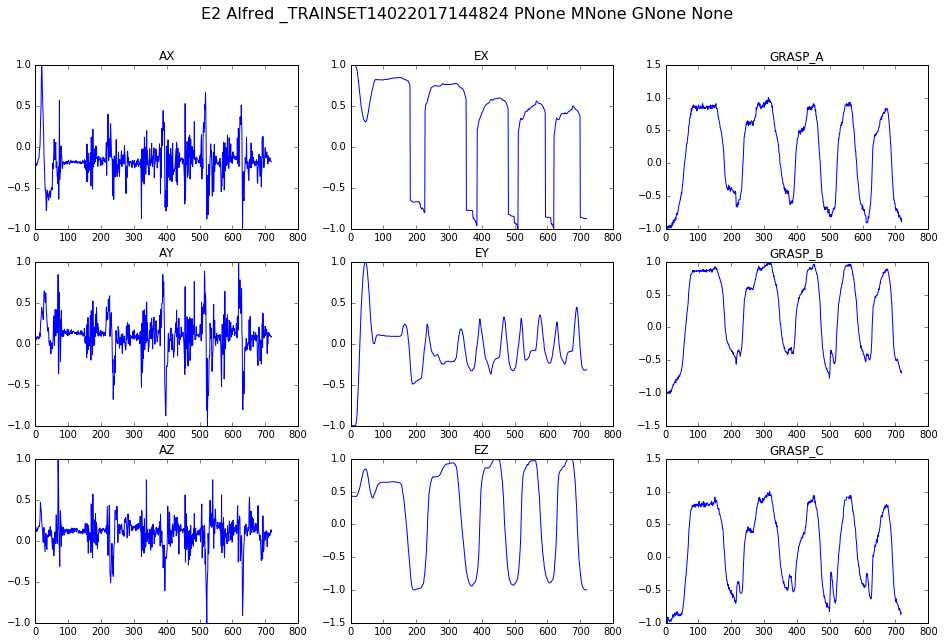

In [320]:
grid_plot(testdata)

### Continuous Prediction

In [317]:
# for our window_size (= signal length of input to Machine Learning)
# we take the average signal length of the trained gestures
window_size = avg_data_len 
window_size

988

In [318]:
# how quickly we step forward
# for now we choose have the window_size
step_size = window_size / 2
# TODO: set in milliseconds - convert to sample length
step_size

494